<a href="https://colab.research.google.com/github/Muhammad-Ahmed22/FDA-Riskified/blob/main/Riskified_Final_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# E-Commerce Fraud Detection: A Machine Learning Approach

## Project Overview

This project aims to tackle the significant challenge of fraud in e-commerce transactions. Drawing inspiration from companies like Riskified that leverage behavioral machine learning, we will develop a model to identify and predict fraudulent transactions. The process involves:
1.  Loading and understanding the transactional data and IP geolocation data.
2.  Performing Exploratory Data Analysis (EDA) to uncover initial patterns.
3.  Extensive Feature Engineering to create meaningful signals for the models, including behavioral attributes.
4.  Preprocessing the data for machine learning.
5.  Experimenting with different modeling strategies, including feature selection.
6.  Training and evaluating several machine learning algorithms.
7.  Optimizing the best model and its prediction threshold to achieve a strong balance between detecting fraud and minimizing false positives, focusing on the F1-score.

**Target Variable:** `class` (0 for legitimate, 1 for fraudulent transaction).

## Phase 1: Setup, Data Loading, and Initial Exploration

In [ ]:
# --- 0. Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar # For month/day name feature engineering
import warnings
import time # To time some operations

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline as SklearnPipeline # Renamed for clarity
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression # For initial baseline if desired
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    classification_report, roc_auc_score, precision_score,
    recall_score, f1_score, confusion_matrix, make_scorer,
    roc_curve, auc as auc_score # Renamed auc from sklearn.metrics
)
from imblearn.over_sampling import SMOTE # For imbalance handling

# Configure Pandas and Warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100) # Show more columns
pd.set_option('display.width', 1000)    # Wider display
pd.set_option('display.float_format', lambda x: '%.5f' % x) # Format floats

print("Libraries imported successfully.")

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
print("Google Drive mounted successfully.")

Libraries imported successfully.
Mounted at /content/drive
Google Drive mounted successfully.


### 1.1 Data Loading
We will load three datasets:
- `Fraud_Data.csv`: Contains user transaction information.
- `IpAddress_to_Country.csv`: Maps IP address ranges to countries.
- `Series_first_purchase.csv`: A pre-computed series indicating if a purchase is the first for a given device ID (as per an idea from an external notebook).

In [ ]:
# --- 1. Load Data ---
print("--- 1.1 Loading Data ---")
DATA_LOAD_SUCCESS = False
try:
    # --- UPDATE THESE PATHS TO YOUR ACTUAL FILE LOCATIONS ---
    # Example for Google Colab:
    # from google.colab import drive
    # drive.mount('/content/drive', force_remount=True)
    # base_path = '/content/drive/MyDrive/FDA Final/'

    # Example for local execution:
    base_path = '/content/drive/MyDrive/FDA Final/' # Assuming files are in the same directory as the notebook

    fraud_data_path = base_path + 'Fraud_Data.csv'
    ip_table_path = base_path + 'IpAddress_to_Country.csv'
    # See the markdown below to check where this file has come from
    first_purchase_series_path = base_path + "Series_first_purchase.csv"


    dataset_orig = pd.read_csv(fraud_data_path)
    ip_table_orig = pd.read_csv(ip_table_path)
    print(f"Fraud_Data.csv loaded: {dataset_orig.shape}")
    print(f"IpAddress_to_Country.csv loaded: {ip_table_orig.shape}")
    DATA_LOAD_SUCCESS = True
except FileNotFoundError as e:
    print(f"ERROR: Data file(s) not found. {e}")
    print("Please check paths. Will attempt to proceed with DUMMY data for structure demonstration.")
except Exception as e:
    print(f"An error occurred during data loading: {e}")
    print("Please check paths. Will attempt to proceed with DUMMY data for structure demonstration.")


if not DATA_LOAD_SUCCESS:
    print("Creating DUMMY data as actual files were not found.")
    dataset_orig = pd.DataFrame({
        'user_id': [f"id_{i}" for i in range(10000)], # Larger dummy dataset
        'signup_time': pd.to_datetime(pd.Timestamp('2015-01-01') + pd.to_timedelta(np.random.randint(0, 365*24*60*60, 10000), unit='s')),
        'purchase_time': pd.to_datetime(pd.Timestamp('2015-01-01') + pd.to_timedelta(np.random.randint(3600, (365+90)*24*60*60, 10000), unit='s')),
        'purchase_value': np.random.randint(5, 200, 10000),
        'device_id': [f"device_{np.random.randint(0,2000)}" for _ in range(10000)],
        'source': np.random.choice(['SEO', 'Ads', 'Direct'], 10000),
        'browser': np.random.choice(['Chrome', 'Safari', 'Firefox', 'IE', 'Opera'], 10000),
        'sex': np.random.choice(['M', 'F'], 10000),
        'age': np.random.randint(18, 75, 10000),
        'ip_address': np.random.uniform(1e8, 4e9, 10000).astype(np.int64),
        'class': np.random.choice([0, 1], 10000, p=[0.92, 0.08]) # Approx 8% fraud rate
    })
    dataset_orig['purchase_time'] = dataset_orig.apply(lambda row: row['signup_time'] + pd.to_timedelta(np.random.randint(300, 30*24*60*60), unit='s'), axis=1) # Ensure purchase > signup

    ip_table_orig = pd.DataFrame({ # More extensive dummy IP table
        'lower_bound_ip_address': np.arange(1e8, 4e9, 1e6)[:-1],
        'upper_bound_ip_address': np.arange(1e8 + 1e6 -1, 4e9, 1e6),
        'country': [np.random.choice(['USA','CAN','GBR','DEU','FRA','JPN','CHN','IND','BRA','AUS','NGA','RUS','MEX','ZAF','ARG']) for _ in range(len(np.arange(1e8, 4e9, 1e6)[:-1]))]
    })
    # Create dummy first_purchase_series_path if it's used by FE12
    try:
        dummy_first_purchase = pd.DataFrame({'first_purchase_flag_dummy': np.random.randint(0,2,len(dataset_orig))})
        dummy_first_purchase.to_csv(first_purchase_series_path, index=False)
        print(f"Created dummy '{first_purchase_series_path}'")
    except:
        print(f"Could not create dummy '{first_purchase_series_path}'. FE12 might fail if path is incorrect.")


# Make copies to work on
dataset = dataset_orig.copy()
ip_table = ip_table_orig.copy()

print("\nInitial dataset head:")
print(dataset.head())
print("\nInitial dataset info:")
dataset.info()
print("\nInitial IP table head:")
print(ip_table.head())

--- 1.1 Loading Data ---
Fraud_Data.csv loaded: (151112, 11)
IpAddress_to_Country.csv loaded: (138846, 3)

Initial dataset head:
   user_id          signup_time        purchase_time  purchase_value      device_id source browser sex  age       ip_address  class
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34  QVPSPJUOCKZAR    SEO  Chrome   M   39  732758368.79972      0
1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16  EOGFQPIZPYXFZ    Ads  Chrome   F   53  350311387.86591      0
2     1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15  YSSKYOSJHPPLJ    SEO   Opera   M   53 2621473820.11095      1
3   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44  ATGTXKYKUDUQN    SEO  Safari   M   41 3840542443.91396      0
4   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39  NAUITBZFJKHWW    Ads  Safari   M   45  415583117.45271      0

Initial dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112

Understanding the FE file



### 1.2 Exploratory Data Analysis (EDA)
Let's explore the data to understand its structure, identify potential issues, and find initial patterns related to fraud.


--- 1.2 Performing EDA ---

Distribution of Target Variable 'class':
class
0   90.63542
1    9.36458
Name: proportion, dtype: float64


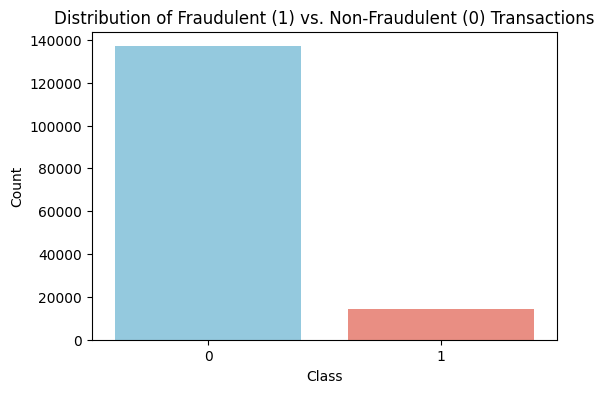

Observation: The dataset is imbalanced, with a small percentage of fraudulent transactions. This needs to be handled during modeling.

Missing values per column:
user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

Descriptive statistics for numerical features:
           user_id  purchase_value          age       ip_address        class
count 151112.00000    151112.00000 151112.00000     151112.00000 151112.00000
mean  200171.04097        36.93537     33.14070 2152145330.95883      0.09365
std   115369.28502        18.32276      8.61773 1248497030.10043      0.29134
min        2.00000         9.00000     18.00000      52093.49689      0.00000
25%   100642.50000        22.00000     27.00000 1085933882.53156      0.00000
50%   199958.00000        35.00000     33.00000 2154770162.40662      0.00000
75%   30005

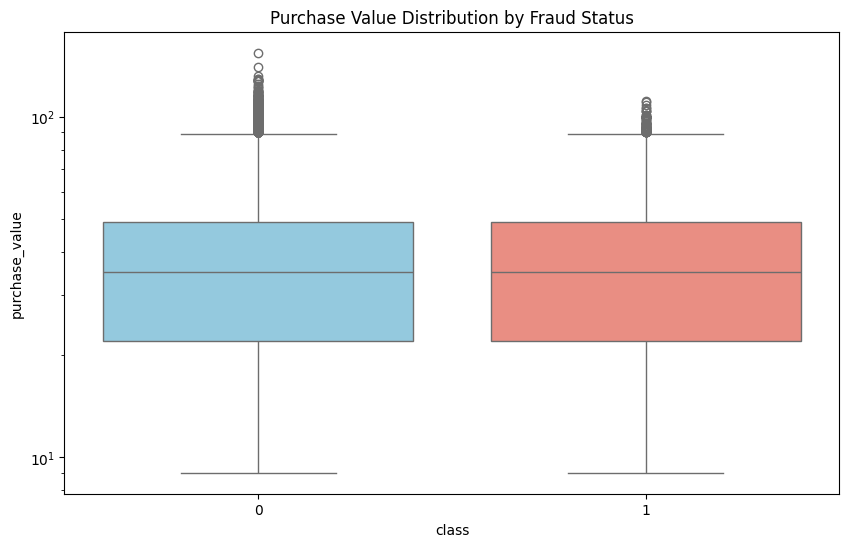

Observation: Fraudulent transactions might have different purchase value patterns (e.g., very high or very low for testing).


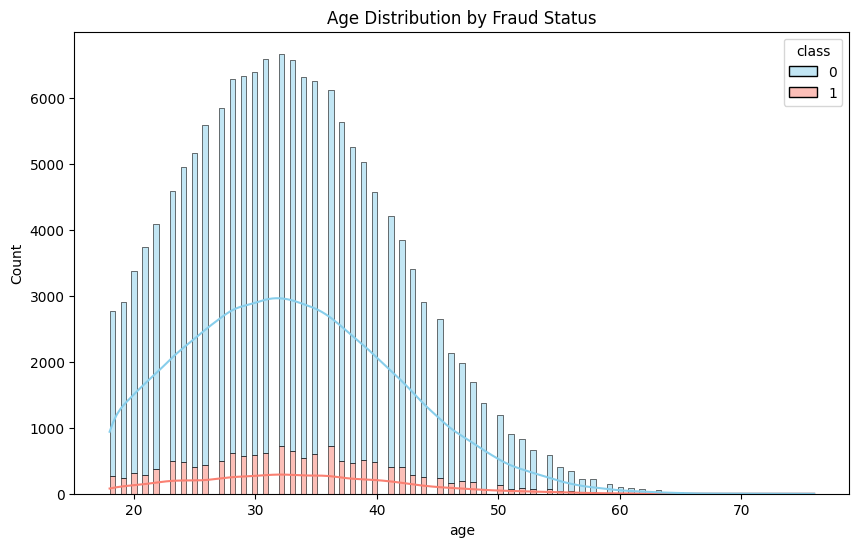

Observation: Certain age groups might be more susceptible or targeted for fraud.


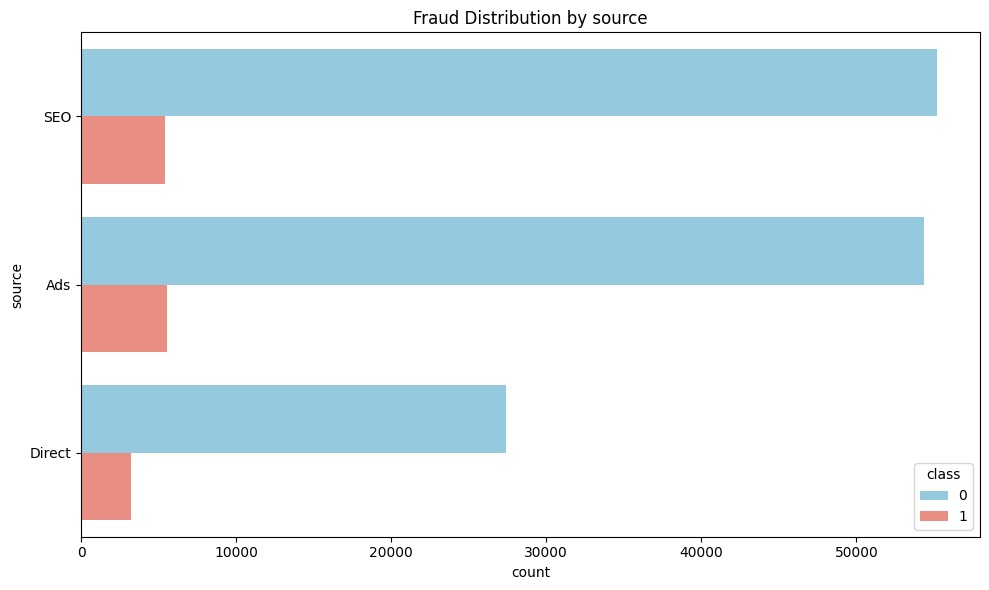

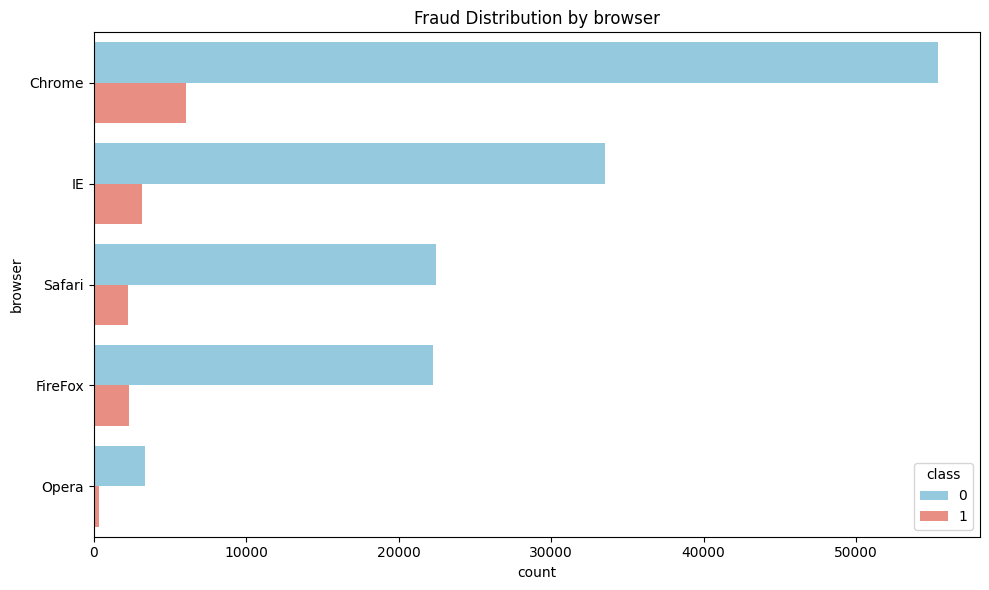

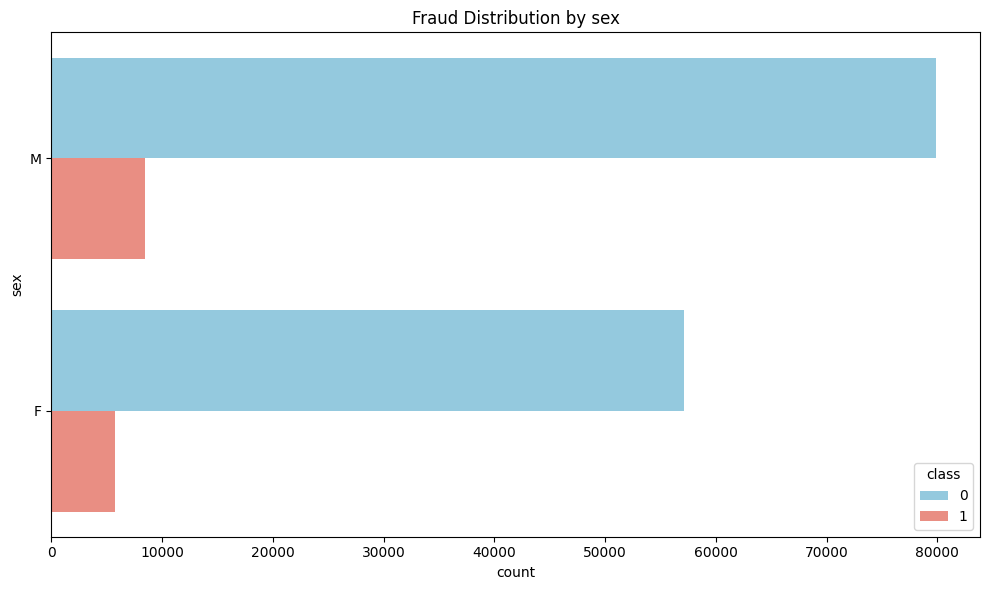

Observation: Different sources, browsers, or sexes might exhibit varying fraud rates.


In [ ]:
print("\n--- 1.2 Performing EDA ---")

# A. Target Variable Distribution
print("\nDistribution of Target Variable 'class':")
class_dist = dataset['class'].value_counts(normalize=True) * 100
print(class_dist)
plt.figure(figsize=(6, 4))
sns.countplot(x='class', data=dataset, palette=['skyblue', 'salmon'])
plt.title('Distribution of Fraudulent (1) vs. Non-Fraudulent (0) Transactions')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()
print("Observation: The dataset is imbalanced, with a small percentage of fraudulent transactions. This needs to be handled during modeling.")

# B. Missing Values
print("\nMissing values per column:")
print(dataset.isnull().sum())
# Based on problem description, datasets are usually clean. If NaNs, imputation will be handled in preprocessing.

# C. Basic Stats for Numerical Features
print("\nDescriptive statistics for numerical features:")
print(dataset.describe())

# D. Visualizing Key Features vs. Fraud
# We will do more detailed visualizations after some initial feature engineering (like IP to Country)

# Example: Purchase Value vs. Fraud
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='purchase_value', data=dataset, palette=['skyblue', 'salmon'])
plt.title('Purchase Value Distribution by Fraud Status')
plt.yscale('log') # Use log scale if purchase_value is highly skewed
plt.show()
print("Observation: Fraudulent transactions might have different purchase value patterns (e.g., very high or very low for testing).")

# Example: Age vs. Fraud
plt.figure(figsize=(10, 6))
sns.histplot(data=dataset, x='age', hue='class', kde=True, multiple="stack", palette=['skyblue', 'salmon'])
plt.title('Age Distribution by Fraud Status')
plt.show()
print("Observation: Certain age groups might be more susceptible or targeted for fraud.")

# Categorical Features (Source, Browser, Sex) vs. Fraud
cat_eda_features = ['source', 'browser', 'sex']
for feature in cat_eda_features:
    if feature in dataset.columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(data=dataset, y=feature, hue='class', palette=['skyblue', 'salmon'], order = dataset[feature].value_counts().index[:10]) # Top 10 categories
        plt.title(f'Fraud Distribution by {feature}')
        plt.tight_layout()
        plt.show()
print("Observation: Different sources, browsers, or sexes might exhibit varying fraud rates.")

## Phase 2: Feature Engineering
This is a critical phase where we create new features from existing data to provide stronger signals to our machine learning models. We will incorporate several strategies, including time-based features, IP geolocation, and behavioral attributes inspired by common fraud patterns and external notebook ideas.

In [ ]:
print("\n\n--- PHASE 2: FEATURE ENGINEERING ---")
start_fe_time = time.time()

# --- 2.A. IP to Country Mapping ---
print("\n--- 2.A. Mapping IP to Country (Efficient Method) ---")
# (Using the efficient interval join logic from our previous discussions)
# Ensure data types are correct
ip_table['lower_bound_ip_address'] = ip_table['lower_bound_ip_address'].astype(np.int64)
ip_table['upper_bound_ip_address'] = ip_table['upper_bound_ip_address'].astype(np.int64)
dataset['ip_address_numeric'] = dataset['ip_address'].astype(np.int64) # Keep original ip_address if needed, use numeric for mapping

# Sort ip_table by lower bound for searchsorted
ip_table = ip_table.sort_values('lower_bound_ip_address').reset_index(drop=True)

# Efficient mapping
sorted_lower_bounds = ip_table['lower_bound_ip_address']
# Find insertion points for each IP address in the sorted lower bounds
candidate_indices = sorted_lower_bounds.searchsorted(dataset['ip_address_numeric'], side='right') - 1

# Initialize 'IP_country' column
dataset['IP_country'] = "Unknown_Country" # Default value

# Create a mask for valid candidate_indices (must be >= 0)
valid_candidate_mask = (candidate_indices >= 0)

# Filter dataset and candidate_indices to only valid ones
dataset_ips_to_check = dataset.loc[valid_candidate_mask, 'ip_address_numeric']
ip_table_indices_for_candidates = candidate_indices[valid_candidate_mask]

# Retrieve the IP range bounds and country names from ip_table for these candidate rows
candidate_lower_ips = ip_table.loc[ip_table_indices_for_candidates, 'lower_bound_ip_address'].values
candidate_upper_ips = ip_table.loc[ip_table_indices_for_candidates, 'upper_bound_ip_address'].values
candidate_countries = ip_table.loc[ip_table_indices_for_candidates, 'country'].values

# Check if the transaction IPs fall within their candidate IP ranges
match_condition = (dataset_ips_to_check.values >= candidate_lower_ips) & \
                  (dataset_ips_to_check.values <= candidate_upper_ips)

# Get original indices from 'dataset' where a true match occurred
original_dataset_indices_of_matches = dataset.index[valid_candidate_mask][match_condition]

# Assign the identified countries
dataset.loc[original_dataset_indices_of_matches, 'IP_country'] = candidate_countries[match_condition]

print(f"  IP to Country mapping complete. {(dataset['IP_country'] == 'Unknown_Country').sum()} IPs remain unknown.")
print(dataset[['ip_address_numeric', 'IP_country']].head())


# --- 2.B. Time-based Feature Engineering ---
print("\n--- 2.B. Engineering Time-based Features ---")
# Ensure datetime format
dataset.signup_time = pd.to_datetime(dataset.signup_time)
dataset.purchase_time = pd.to_datetime(dataset.purchase_time)

# Difference between purchase and signup
dataset["seconds_since_signup"] = (dataset.purchase_time - dataset.signup_time).dt.total_seconds()
dataset["seconds_since_signup"] = np.maximum(0, dataset["seconds_since_signup"]) # Floor at 0

# Purchase time components
dataset['purchase_hour_orig'] = dataset.purchase_time.dt.hour
dataset['purchase_day_of_week_orig'] = dataset.purchase_time.dt.dayofweek
dataset['purchase_day_of_month_orig'] = dataset.purchase_time.dt.day
dataset['purchase_month_orig'] = dataset.purchase_time.dt.month # For string name
dataset['purchase_weekday_str'] = dataset.purchase_time.dt.day_name() # For string name
dataset['purchase_is_weekend'] = (dataset['purchase_day_of_week_orig'] >= 5).astype(int)

# Signup time components
dataset['signup_hour_orig'] = dataset.signup_time.dt.hour
dataset['signup_day_of_week_orig'] = dataset.signup_time.dt.dayofweek
dataset['signup_is_weekend'] = (dataset['signup_day_of_week_orig'] >= 5).astype(int)


# --- 2.C. Cyclical Encoding for Time Features ---
print("\n--- 2.C. Applying Cyclical Encoding for Time ---")
def encode_cyclical(df, col_original_name, max_val):
    if col_original_name not in df.columns:
        print(f"    Warning: Column '{col_original_name}' not found for cyclical encoding.")
        return df
    df[col_original_name + '_sin'] = np.sin(2 * np.pi * df[col_original_name] / max_val)
    df[col_original_name + '_cos'] = np.cos(2 * np.pi * df[col_original_name] / max_val)
    return df

cyclical_features_to_encode = {
    'purchase_hour_orig': 24, 'signup_hour_orig': 24,
    'purchase_day_of_week_orig': 7, 'signup_day_of_week_orig': 7,
    'purchase_day_of_month_orig': 31 # Max days in a month
}
# Store original column names that will be replaced by sin/cos versions for later dropping
engineered_time_cols_to_drop = list(cyclical_features_to_encode.keys())

for col, max_v in cyclical_features_to_encode.items():
    dataset = encode_cyclical(dataset, col, max_v)
print("  Cyclical encoding complete for hour, day_of_week, day_of_month.")


# --- 2.D. Advanced Behavioral Features (Inspired by shared notebook) ---
print("\n--- 2.D. Engineering Advanced Behavioral Features ---")

# FE 6 (Notebook): countries_from_device
if 'device_id' in dataset.columns and 'IP_country' in dataset.columns:
    print("  Engineering 'countries_from_device'...")
    # Ensure IP_country does not have NaNs for groupby, or handle them
    dataset['IP_country_for_fe6'] = dataset['IP_country'].fillna('Unknown_FE_Country')
    country_count_temp = dataset.groupby(by=["device_id", "IP_country_for_fe6"])['class'].count().reset_index() # Use any col for count
    country_count_agg = pd.DataFrame(country_count_temp.groupby(by="device_id")['IP_country_for_fe6'].count())
    country_count_agg.rename(columns={"IP_country_for_fe6": "countries_from_device"}, inplace=True)
    dataset = dataset.merge(country_count_agg, on="device_id", how='left')
    dataset["countries_from_device"].fillna(1, inplace=True) # Devices with 1 country might not show if only 1 entry
    dataset.drop(columns=['IP_country_for_fe6'], inplace=True, errors='ignore')
else: print("    Skipping 'countries_from_device': missing 'device_id' or 'IP_country'.")

# FE 7 (Notebook): risk_country_cat (Calculated on a temporary train split to reduce leakage)
if 'IP_country' in dataset.columns:
    print("  Engineering 'risk_country_cat' (with reduced leakage)...")
    temp_train_for_risk, _ = train_test_split(dataset[['IP_country', 'class']], test_size=0.01, random_state=123, stratify=dataset['class'])
    risk_country_map = pd.DataFrame(temp_train_for_risk.groupby(by="IP_country")['class'].mean().fillna(0)) # Fill NaN fraud rates with 0
    risk_country_map["risk_country_cat"] = risk_country_map["class"].apply(lambda x:
        "Very High risk" if x > 0.25 else "High risk" if x > 0.05 else "Medium risk" if x > 0.01 else "Low risk")
    dataset = dataset.merge(risk_country_map[["risk_country_cat"]], on="IP_country", how='left')
    dataset["risk_country_cat"].fillna("Low risk", inplace=True) # For new countries in test or unmapped
else: print("    Skipping 'risk_country_cat': 'IP_country' missing.")

# FE 8 (Notebook): quick_purchase_flag
if 'seconds_since_signup' in dataset.columns:
    dataset["quick_purchase_flag"] = (dataset.seconds_since_signup < 30).astype(int) # Purchase within 30s of signup
else: print("    Skipping 'quick_purchase_flag': 'seconds_since_signup' missing.")

# FE 10 (Notebook): age_category
if 'age' in dataset.columns:
    dataset["age_cat"] = dataset.age.apply(lambda x:
        "<40" if x < 40 else "40-49" if x < 50 else "50-59" if x < 60 else "60-69" if x < 70 else ">70")
else: print("    Skipping 'age_cat': 'age' missing.")

# FE 11 (Notebook): period_of_the_day (using purchase_hour_orig)
if 'purchase_hour_orig' in dataset.columns:
    dataset["period_day_cat"] = dataset['purchase_hour_orig'].apply(lambda x:
        "late night" if x < 4 else "early morning" if x < 8 else "morning" if x < 12 else
        "early arvo" if x < 16 else "arvo" if x < 20 else "evening")
else: print("    Skipping 'period_day_cat': 'purchase_hour_orig' missing.")

# FE 12 (Notebook): first_purchase_flag
print("  Loading 'first_purchase_flag'...")
try:
    first_purchase_series = pd.read_csv(first_purchase_series_path)
    if len(first_purchase_series) == len(dataset):
        dataset["first_purchase_flag"] = first_purchase_series.iloc[:, 0].values # Assumes single column CSV
    else: print(f"    WARNING: Length mismatch for '{first_purchase_series_path}'. Skipping FE 12.")
except FileNotFoundError: print(f"    WARNING: '{first_purchase_series_path}' not found. Skipping FE 12.")
except Exception as e: print(f"    WARNING: Error loading '{first_purchase_series_path}': {e}. Skipping FE 12.")


# --- 2.E. Log Transformations & Interactions (from our V2/V3 work) ---
print("\n--- 2.E. Log Transformations and Interaction Features ---")
if 'purchase_value' in dataset.columns:
    dataset['purchase_value_log'] = np.log1p(dataset['purchase_value'])
if 'seconds_since_signup' in dataset.columns:
    dataset['time_since_signup_seconds_log'] = np.log1p(dataset['seconds_since_signup'])

# Define column names for interactions carefully
pv_interact_col = 'purchase_value_log' if 'purchase_value_log' in dataset.columns else 'purchase_value'
tss_interact_col = 'time_since_signup_seconds_log' if 'time_since_signup_seconds_log' in dataset.columns else 'seconds_since_signup'
age_interact_col = 'age' # Assuming original 'age' is still present for interaction

if pv_interact_col in dataset.columns and tss_interact_col in dataset.columns and tss_interact_col in dataset and dataset[tss_interact_col].dtype in [np.float64, np.int64]:
    dataset[f'{pv_interact_col}_per_{tss_interact_col}'] = dataset[pv_interact_col] / (dataset[tss_interact_col] + 1e-6) # Add epsilon
if pv_interact_col in dataset.columns and age_interact_col in dataset.columns and dataset[age_interact_col].dtype in [np.int64, np.float64]:
    dataset[f'{pv_interact_col}_per_age'] = dataset[pv_interact_col] / (dataset[age_interact_col].replace(0, 1e-6) + 1e-6) # Replace 0 age and add epsilon

# --- 2.F. Frequency Encoding for device_id ---
print("\n--- 2.F. Frequency Encoding 'device_id' ---")
if 'device_id' in dataset.columns:
    device_freq_map = dataset['device_id'].value_counts(normalize=True)
    dataset['device_id_freq'] = dataset['device_id'].map(device_freq_map)
    dataset['device_id_freq'].fillna(0, inplace=True) # For device_ids only in test during transform
else: print("    Skipping 'device_id_freq': 'device_id' missing.")


end_fe_time = time.time()
print(f"\nFeature Engineering Complete. Time taken: {end_fe_time - start_fe_time:.2f} seconds.")
print("Final dataset shape after FE:", dataset.shape)
print("\nSample of dataset after Feature Engineering (first 5 rows):")
print(dataset.head().T) # Transpose for better viewing if many columns

# --- Save the fully engineered dataset (dataset_v3 equivalent) ---
try:
    dataset.to_csv("dataset_fully_engineered.csv", index=False)
    print("\nSuccessfully saved 'dataset_fully_engineered.csv'")
except Exception as e:
    print(f"Error saving engineered dataset: {e}")



--- PHASE 2: FEATURE ENGINEERING ---

--- 2.A. Mapping IP to Country (Efficient Method) ---
  IP to Country mapping complete. 21966 IPs remain unknown.
   ip_address_numeric       IP_country
0           732758368            Japan
1           350311387    United States
2          2621473820    United States
3          3840542443  Unknown_Country
4           415583117    United States

--- 2.B. Engineering Time-based Features ---

--- 2.C. Applying Cyclical Encoding for Time ---
  Cyclical encoding complete for hour, day_of_week, day_of_month.

--- 2.D. Engineering Advanced Behavioral Features ---
  Engineering 'countries_from_device'...
  Engineering 'risk_country_cat' (with reduced leakage)...
  Loading 'first_purchase_flag'...

--- 2.E. Log Transformations and Interaction Features ---

--- 2.F. Frequency Encoding 'device_id' ---

Feature Engineering Complete. Time taken: 1.41 seconds.
Final dataset shape after FE: (151112, 44)

Sample of dataset after Feature Engineering (first 5 ro

### Intermediate EDA: Visualizing Engineered Features
Let's look at some of the newly engineered categorical features and their relationship with fraud.


--- Intermediate EDA on Engineered Features ---


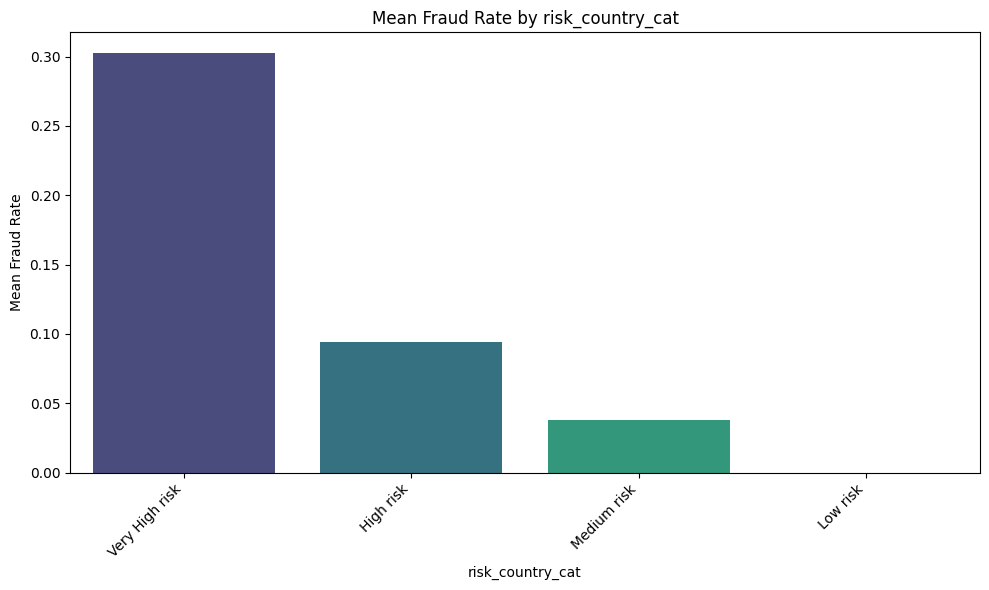

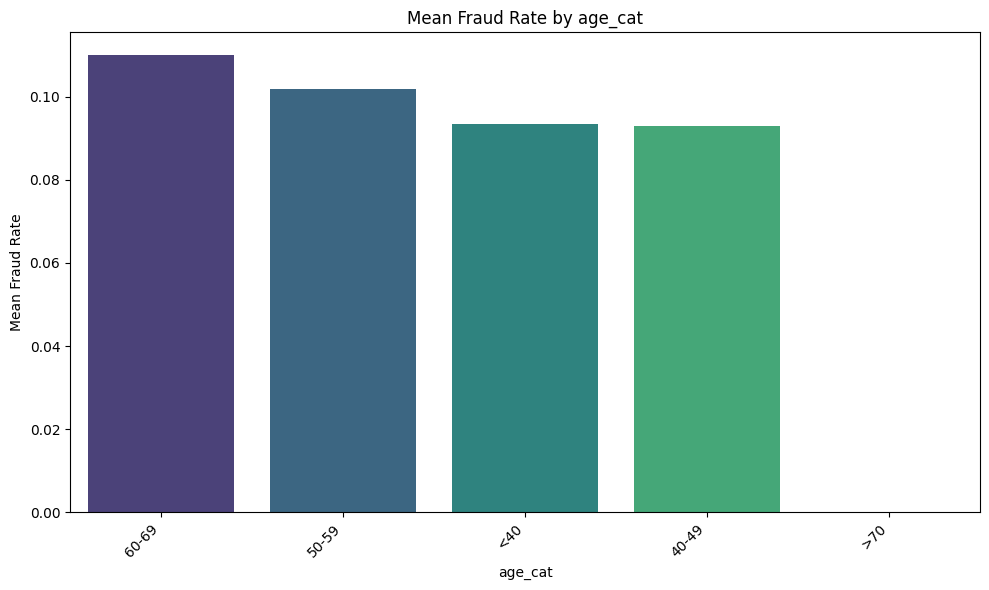

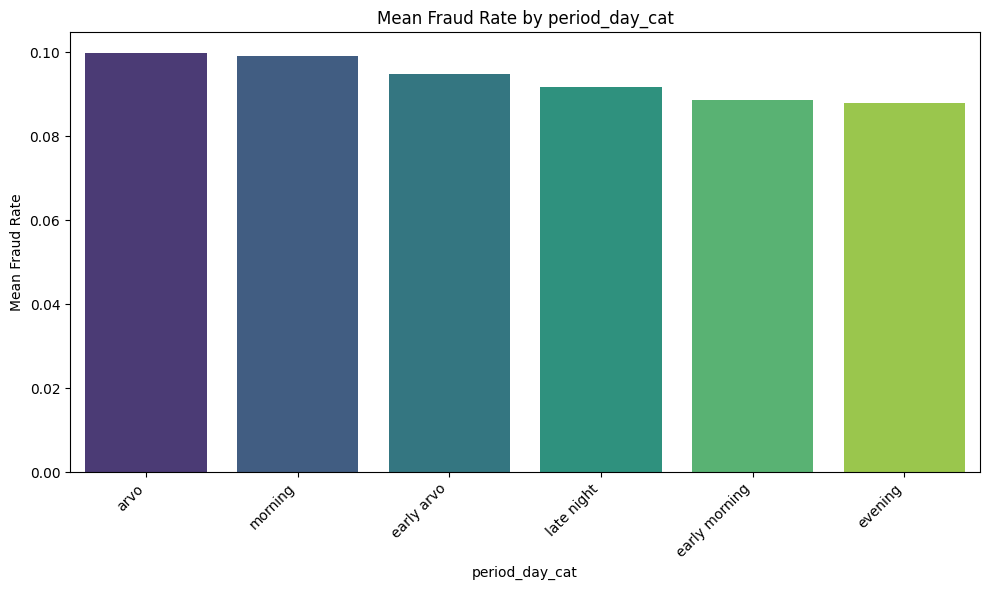

In [ ]:
print("\n--- Intermediate EDA on Engineered Features ---")
engineered_cat_features_to_plot = ['risk_country_cat', 'age_cat', 'period_day_cat']
# Add 'freq_device_cat' or 'freq_same_purchase_cat' if you implemented them from the other notebook

for feature in engineered_cat_features_to_plot:
    if feature in dataset.columns:
        plt.figure(figsize=(10, 6))
        # Calculate fraud rate per category
        fraud_rate = dataset.groupby(feature)['class'].mean().sort_values(ascending=False)
        sns.barplot(x=fraud_rate.index, y=fraud_rate.values, palette="viridis")
        plt.title(f'Mean Fraud Rate by {feature}')
        plt.ylabel('Mean Fraud Rate')
        plt.xlabel(feature)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Skipping visualization for {feature}, not found.")

### 2.1 Initial Model Bake-off (All Engineered Features)
Before proceeding to more advanced techniques like feature selection or fine-grained tuning, we will conduct an initial comparison of several standard machine learning models. This will help us identify the most promising algorithm types for this fraud detection task using our comprehensive set of engineered features.

We will evaluate:
- Logistic Regression
- Decision Tree
- Random Forest
- XGBoost
- K-Nearest Neighbors

All models will be trained on the full feature set after preprocessing (including imputation, scaling for numerical features, and one-hot encoding for categoricals). SMOTE will be applied to the training data to handle class imbalance for this initial comparison.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SklearnPipeline # Renamed to avoid conflict if you use imblearn.pipeline
from imblearn.over_sampling import SMOTE # Assuming you're using imblearn
!pip install catboost lightgbm imbalanced-learn

# Import all model classes
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC # Faster for linear SVM, or use SVC(kernel='linear')
import lightgbm as lgb # pip install lightgbm
import catboost as cb  # pip install catboost

from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score

# --- 2.1 Initial Model Bake-off ---
print("\n\n--- PHASE 2.1: INITIAL MODEL BAKE-OFF (ALL ENGINEERED FEATURES - 10 MODELS) ---")

df_for_bake_off = dataset.copy()

# --- Define X and y for Bake-off ---
y_bake_off = df_for_bake_off['class']

cols_to_drop_bake_off = [
    'class', 'user_id', 'signup_time', 'purchase_time', 'ip_address', 'ip_address_numeric', 'device_id',
    'IP_country', # Original IP_country string if risk_country_cat/IP_country_freq is used
]
if 'engineered_time_cols_to_drop' in locals() and engineered_time_cols_to_drop:
    cols_to_drop_bake_off.extend(engineered_time_cols_to_drop)
else:
    # Fallback based on common FE steps
    cols_to_drop_bake_off.extend([
        'purchase_hour_orig', 'signup_hour_orig',
        'purchase_day_of_week_orig', 'signup_day_of_week_orig',
        'purchase_day_of_month_orig'
    ])

# Conditional drops based on your FE (if log transformed or binned versions are used)
if 'purchase_value_log' in df_for_bake_off.columns and 'purchase_value' in df_for_bake_off.columns:
    if 'purchase_value' not in cols_to_drop_bake_off: cols_to_drop_bake_off.append('purchase_value')
if 'time_since_signup_seconds_log' in df_for_bake_off.columns and 'seconds_since_signup' in df_for_bake_off.columns: # Assuming 'seconds_since_signup' is the original
    if 'seconds_since_signup' not in cols_to_drop_bake_off: cols_to_drop_bake_off.append('seconds_since_signup')
if 'age_cat' in df_for_bake_off.columns and 'age' in df_for_bake_off.columns:
    if 'age' not in cols_to_drop_bake_off: cols_to_drop_bake_off.append('age')


X_bake_off = df_for_bake_off.drop(columns=list(set(cols_to_drop_bake_off)), errors='ignore')
print(f"Shape of X for Bake-off: {X_bake_off.shape}")
if X_bake_off.empty or X_bake_off.shape[1] == 0:
    raise ValueError("X_bake_off is empty or has no columns after dropping. Check cols_to_drop_bake_off and your DataFrame.")


# --- Identify Categorical and Numerical Columns for Bake-off ---
categorical_cols_bake_off = X_bake_off.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols_bake_off = [col for col in X_bake_off.columns if col not in categorical_cols_bake_off] # All others assumed numeric

print(f"Numerical Cols for Bake-off ({len(numerical_cols_bake_off)}): {numerical_cols_bake_off[:5]}...")
print(f"Categorical Cols for Bake-off ({len(categorical_cols_bake_off)}): {categorical_cols_bake_off[:5]}...")

# --- Preprocessing Pipeline for Bake-off ---
# Using SklearnPipeline for scikit-learn's Pipeline
numeric_transformer_bake_off = SklearnPipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                                      ('scaler', StandardScaler())])
categorical_transformer_bake_off = SklearnPipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='_MISSING_')),
                                                          ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))])
transformers_bake_off = []
if numerical_cols_bake_off:
    transformers_bake_off.append(('num', numeric_transformer_bake_off, numerical_cols_bake_off))
if categorical_cols_bake_off:
    transformers_bake_off.append(('cat', categorical_transformer_bake_off, categorical_cols_bake_off))

if not transformers_bake_off:
    raise ValueError("No columns identified for bake-off preprocessing! Check numerical/categorical column identification.")
preprocessor_bake_off = ColumnTransformer(transformers=transformers_bake_off, remainder='drop')


# --- Train-Test Split for Bake-off ---
X_train_bo, X_test_bo, y_train_bo, y_test_bo = train_test_split(
    X_bake_off, y_bake_off, test_size=0.25, random_state=42, stratify=y_bake_off
)

# --- Apply Preprocessing for Bake-off ---
print("Preprocessing data for Bake-off...")
X_train_processed_bo = preprocessor_bake_off.fit_transform(X_train_bo)
X_test_processed_bo = preprocessor_bake_off.transform(X_test_bo)

# --- Get Processed Feature Names for Bake-off ---
processed_feature_names_bo = []
try:
    for name, fitted_transformer_pipeline, columns in preprocessor_bake_off.transformers_:
        if fitted_transformer_pipeline == 'drop' or not columns: # Check if columns list is empty
            continue
        if name == 'num' and numerical_cols_bake_off: # Check if numerical_cols_bake_off is not empty
            processed_feature_names_bo.extend(columns) # Original names for scaled numeric
        elif name == 'cat' and categorical_cols_bake_off: # Check if categorical_cols_bake_off is not empty
            # Access the OneHotEncoder step within the SklearnPipeline
            if hasattr(fitted_transformer_pipeline, 'named_steps') and 'onehot' in fitted_transformer_pipeline.named_steps:
                ohe_encoder = fitted_transformer_pipeline.named_steps['onehot']
                processed_feature_names_bo.extend(ohe_encoder.get_feature_names_out(columns))
    if X_train_processed_bo.shape[1] != len(processed_feature_names_bo):
        print(f"Warning: Feature name count mismatch. Processed cols: {X_train_processed_bo.shape[1]}, Names found: {len(processed_feature_names_bo)}. Using generic names.")
        processed_feature_names_bo = [f"feat_{i}" for i in range(X_train_processed_bo.shape[1])]
except Exception as e_feat_names:
    print(f"Error getting feature names: {e_feat_names}. Using generic names.")
    processed_feature_names_bo = [f"feat_{i}" for i in range(X_train_processed_bo.shape[1])]

print(f"Shape of X_train_processed_bo: {X_train_processed_bo.shape}, Num Processed Features: {len(processed_feature_names_bo)}")


# --- Handle Class Imbalance with SMOTE for Bake-off ---
print("Applying SMOTE for Bake-off models...")
smote_bo = SMOTE(random_state=42)
X_train_resampled_bo, y_train_resampled_bo = smote_bo.fit_resample(X_train_processed_bo, y_train_bo)
print(f"Shape of X_train_resampled_bo: {X_train_resampled_bo.shape}")


# --- Define Models Dictionary for Bake-off (10 Models) ---
from sklearn.svm import SVC # Make sure this import is used

models_dict_bake_off = {
    "Logistic Regression": LogisticRegression(solver='liblinear', random_state=42, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1),
    "XGBoost": xgb.XGBClassifier(random_state=42, eval_metric='logloss', objective='binary:logistic', use_label_encoder=False),
    "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    "LightGBM": lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1),
    "CatBoost": cb.CatBoostClassifier(random_state=42, verbose=0),
    "Gaussian NB": GaussianNB(),
    "Linear SVM (SVC)": SVC(kernel='linear', probability=True, random_state=42, max_iter=3000), # Increased max_iter just in case
    "AdaBoost": AdaBoostClassifier(random_state=42)
}
# Note for LinearSVC: dual=False is preferred when n_samples > n_features.
# The default is dual=True. If you get convergence warnings, try dual=False or increase max_iter.
# For CatBoost, if you had many categorical features and didn't OHE them, it would handle them internally.
# Here, since we OHE, it works on the transformed data like other models.

# --- Run Bake-off Modeling Pipeline ---
bake_off_results_list = []
for model_name, model_instance in models_dict_bake_off.items():
    try:
        print(f"\n--- Training {model_name} for Bake-off (SMOTE) ---")
        start_time = pd.Timestamp.now()
        model_instance.fit(X_train_resampled_bo, y_train_resampled_bo)
        training_time = (pd.Timestamp.now() - start_time).total_seconds()

        y_pred_bo = model_instance.predict(X_test_processed_bo)
        y_prob_bo = model_instance.predict_proba(X_test_processed_bo)[:, 1] # Prob of positive class

        print(f"Training time: {training_time:.2f}s")
        print(f"Classification Report for {model_name} (Bake-off):")
        print(classification_report(y_test_bo, y_pred_bo, zero_division=0, digits=4))
        roc_auc_bo = roc_auc_score(y_test_bo, y_prob_bo)
        print(f"ROC AUC for {model_name} (Bake-off): {roc_auc_bo:.4f}")

        bake_off_results_list.append({
            'Model': model_name,
            'Precision (Fraud)': precision_score(y_test_bo, y_pred_bo, pos_label=1, zero_division=0),
            'Recall (Fraud)': recall_score(y_test_bo, y_pred_bo, pos_label=1, zero_division=0),
            'F1-score (Fraud)': f1_score(y_test_bo, y_pred_bo, pos_label=1, zero_division=0),
            'ROC AUC': roc_auc_bo,
            'Training Time (s)': training_time
        })
        # Feature importances (if applicable and names are resolved)
        if hasattr(model_instance, 'feature_importances_') and processed_feature_names_bo and \
           len(processed_feature_names_bo) == X_train_resampled_bo.shape[1]:
            imp_df_bo = pd.DataFrame({
                'feature': processed_feature_names_bo,
                'importance': model_instance.feature_importances_
            }).sort_values(by='importance', ascending=False).head(5)
            print(f"Top 5 Feature Importances:\n{imp_df_bo}\n")
    except Exception as e_bo:
        print(f"ERROR training or evaluating {model_name} for Bake-off: {e_bo}")
        bake_off_results_list.append({'Model': model_name, 'Error': str(e_bo), 'Training Time (s)': np.nan})

bake_off_results_df = pd.DataFrame(bake_off_results_list)
print("\n\n========= INITIAL MODEL BAKE-OFF RESULTS (10 MODELS, ALL FEATURES, SMOTE) =========")
if not bake_off_results_df.empty:
    print(bake_off_results_df.sort_values(by=['ROC AUC'], ascending=False))
else:
    print("No bake-off results to display.")



--- PHASE 2.1: INITIAL MODEL BAKE-OFF (ALL ENGINEERED FEATURES - 10 MODELS) ---
Shape of X for Bake-off: (151112, 28)
Numerical Cols for Bake-off (21): ['purchase_month_orig', 'purchase_is_weekend', 'signup_is_weekend', 'purchase_hour_orig_sin', 'purchase_hour_orig_cos']...
Categorical Cols for Bake-off (7): ['source', 'browser', 'sex', 'purchase_weekday_str', 'risk_country_cat']...
Preprocessing data for Bake-off...
Shape of X_train_processed_bo: (113334, 46), Num Processed Features: 46
Applying SMOTE for Bake-off models...
Shape of X_train_resampled_bo: (205442, 46)

--- Training Logistic Regression for Bake-off (SMOTE) ---
Training time: 10.96s
Classification Report for Logistic Regression (Bake-off):
              precision    recall  f1-score   support

           0     0.9667    0.9489    0.9577     34240
           1     0.5803    0.6834    0.6276      3538

    accuracy                         0.9241     37778
   macro avg     0.7735    0.8162    0.7927     37778
weighted avg

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SklearnPipeline

# Import all model classes
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier # KNN doesn't directly support class_weight in scikit-learn for balancing
from sklearn.naive_bayes import GaussianNB # GaussianNB has 'priors' but it's a bit different, often not used for simple balancing
from sklearn.svm import SVC # Using SVC for Linear SVM with probability
import lightgbm as lgb
import catboost as cb

from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score

# --- Assume 'dataset' is your fully engineered DataFrame ---
# (Dummy data creation from previous response, ensure it's run or your actual 'dataset' is loaded)
if 'dataset' not in locals() or dataset.empty:
    print("Creating dummy 'dataset' for bake-off demonstration...")
    num_samples = 1500; num_numerical_dummy = 15; num_categorical_dummy = 5
    feature_cols_num_dummy = [f'num_feat_{i}' for i in range(num_numerical_dummy)]; feature_cols_cat_dummy = [f'cat_feat_{i}' for i in range(num_categorical_dummy)]
    data_dummy = {col: np.random.rand(num_samples) for col in feature_cols_num_dummy}
    for col in feature_cols_cat_dummy: data_dummy[col] = np.random.choice(['A', 'B', 'C', 'D', '_MISSING_'], size=num_samples)
    data_dummy['class'] = np.random.choice([0, 1], size=num_samples, p=[0.9, 0.1])
    data_dummy['user_id'] = range(num_samples); data_dummy['signup_time'] = pd.to_datetime('today'); data_dummy['purchase_time'] = pd.to_datetime('today')
    data_dummy['ip_address'] = np.random.rand(num_samples); data_dummy['ip_address_numeric'] = np.random.rand(num_samples)
    data_dummy['device_id'] = [f'dev_{i}' for i in range(num_samples)]; data_dummy['IP_country'] = np.random.choice(['USA', 'Canada'], size=num_samples)
    data_dummy['purchase_hour_orig'] = np.random.randint(0,24,num_samples)
    dataset = pd.DataFrame(data_dummy)
    engineered_time_cols_to_drop = ['purchase_hour_orig']
    dataset['purchase_value_log'] = np.log1p(dataset['num_feat_0']) if 'num_feat_0' in dataset else None
    dataset['purchase_value'] = dataset['num_feat_0'] if 'num_feat_0' in dataset else None
else:
    print("Using pre-loaded 'dataset' for bake-off.")


# --- 2.1 Initial Model Bake-off (Class Weight Balancing) ---
print("\n\n--- PHASE 2.1: INITIAL MODEL BAKE-OFF (CLASS WEIGHT BALANCING - 10 MODELS) ---")
df_for_bake_off = dataset.copy()
y_bake_off = df_for_bake_off['class']
# (cols_to_drop_bake_off logic from previous response)
cols_to_drop_bake_off = ['class', 'user_id', 'signup_time', 'purchase_time', 'ip_address', 'ip_address_numeric', 'device_id', 'IP_country']
if 'engineered_time_cols_to_drop' in locals() and engineered_time_cols_to_drop: cols_to_drop_bake_off.extend(engineered_time_cols_to_drop)
else: cols_to_drop_bake_off.extend(['purchase_hour_orig', 'signup_hour_orig', 'purchase_day_of_week_orig', 'signup_day_of_week_orig', 'purchase_day_of_month_orig'])
if 'purchase_value_log' in df_for_bake_off.columns and 'purchase_value' in df_for_bake_off.columns:
    if 'purchase_value' not in cols_to_drop_bake_off: cols_to_drop_bake_off.append('purchase_value')
# Add other conditional drops as needed...

X_bake_off = df_for_bake_off.drop(columns=list(set(cols_to_drop_bake_off)), errors='ignore')
print(f"Shape of X for Bake-off: {X_bake_off.shape}")
if X_bake_off.empty or X_bake_off.shape[1] == 0: raise ValueError("X_bake_off is empty. Check drops.")

# (Identify categorical_cols_bake_off and numerical_cols_bake_off from previous response)
categorical_cols_bake_off = X_bake_off.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols_bake_off = [col for col in X_bake_off.columns if col not in categorical_cols_bake_off]
print(f"Numerical Cols for Bake-off ({len(numerical_cols_bake_off)}): {numerical_cols_bake_off[:5]}...")
print(f"Categorical Cols for Bake-off ({len(categorical_cols_bake_off)}): {categorical_cols_bake_off[:5]}...")

# (Preprocessing pipeline preprocessor_bake_off from previous response)
numeric_transformer_bake_off = SklearnPipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer_bake_off = SklearnPipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='_MISSING_')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))])
transformers_bake_off = []
if numerical_cols_bake_off: transformers_bake_off.append(('num', numeric_transformer_bake_off, numerical_cols_bake_off))
if categorical_cols_bake_off: transformers_bake_off.append(('cat', categorical_transformer_bake_off, categorical_cols_bake_off))
if not transformers_bake_off: raise ValueError("No columns for preprocessing!")
preprocessor_bake_off = ColumnTransformer(transformers=transformers_bake_off, remainder='drop')


# --- Train-Test Split for Bake-off ---
X_train_bo, X_test_bo, y_train_bo, y_test_bo = train_test_split(
    X_bake_off, y_bake_off, test_size=0.25, random_state=42, stratify=y_bake_off
)

# --- Apply Preprocessing for Bake-off ---
print("Preprocessing data for Bake-off...")
X_train_processed_bo = preprocessor_bake_off.fit_transform(X_train_bo)
X_test_processed_bo = preprocessor_bake_off.transform(X_test_bo)
# (Get processed_feature_names_bo from previous response)
processed_feature_names_bo = []
try:
    for name, fitted_transformer_pipeline, columns in preprocessor_bake_off.transformers_:
        if fitted_transformer_pipeline == 'drop' or not columns: continue
        if name == 'num' and numerical_cols_bake_off: processed_feature_names_bo.extend(columns)
        elif name == 'cat' and categorical_cols_bake_off:
            if hasattr(fitted_transformer_pipeline, 'named_steps') and 'onehot' in fitted_transformer_pipeline.named_steps:
                ohe_encoder = fitted_transformer_pipeline.named_steps['onehot']
                processed_feature_names_bo.extend(ohe_encoder.get_feature_names_out(columns))
    if X_train_processed_bo.shape[1] != len(processed_feature_names_bo):
        processed_feature_names_bo = [f"feat_{i}" for i in range(X_train_processed_bo.shape[1])]
except Exception: processed_feature_names_bo = [f"feat_{i}" for i in range(X_train_processed_bo.shape[1])]
print(f"Shape of X_train_processed_bo: {X_train_processed_bo.shape}, Num Processed Features: {len(processed_feature_names_bo)}")


# --- Calculate Class Weights/scale_pos_weight ---
# IMPORTANT: Use y_train_bo (original labels of the training split) for this calculation
neg_counts, pos_counts = np.bincount(y_train_bo)
print(f"Training data class counts: Negative={neg_counts}, Positive={pos_counts}")

# For scikit-learn models that take class_weight='balanced' or a dict
sklearn_class_weight = 'balanced' # Default for many, or compute dict: {0:1, 1: neg_counts/pos_counts} if pos_counts > 0 else 'balanced'
if pos_counts > 0:
    sklearn_class_weight_dict = {0: 1, 1: neg_counts / pos_counts}
else: # Handle case with no positive samples in training (unlikely with stratify but good practice)
    sklearn_class_weight_dict = 'balanced'


# For XGBoost, LightGBM, CatBoost that use scale_pos_weight or similar
if pos_counts > 0:
    scale_pos_weight_val = neg_counts / pos_counts
else:
    scale_pos_weight_val = 1 # Default if no positive samples
print(f"Using scale_pos_weight_val: {scale_pos_weight_val:.2f}")
print(f"Using sklearn_class_weight_dict: {sklearn_class_weight_dict}")


# --- Define Models Dictionary for Bake-off (10 Models with Class Weights) ---
models_dict_bake_off = {
    "Logistic Regression": LogisticRegression(solver='liblinear', random_state=42, max_iter=1000, class_weight=sklearn_class_weight_dict),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight=sklearn_class_weight_dict),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1, class_weight=sklearn_class_weight_dict), # or 'balanced_subsample'
    "XGBoost": xgb.XGBClassifier(random_state=42, eval_metric='logloss', objective='binary:logistic', use_label_encoder=False, scale_pos_weight=scale_pos_weight_val),
    "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=-1), # KNN does not have class_weight, will be imbalanced
    "LightGBM": lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1, scale_pos_weight=scale_pos_weight_val), # or class_weight=sklearn_class_weight_dict for LGBM too
    "CatBoost": cb.CatBoostClassifier(random_state=42, verbose=0, scale_pos_weight=scale_pos_weight_val), # or class_weights for CatBoost
    "Gaussian NB": GaussianNB(), # GNB: use 'priors' if you want to adjust, e.g., priors=[(neg_counts/len(y_train_bo)), (pos_counts/len(y_train_bo))]
    #"Linear SVM (SVC)": SVC(kernel='linear', probability=True, random_state=42, max_iter=3000, class_weight=sklearn_class_weight_dict),
    "AdaBoost": AdaBoostClassifier(random_state=42) # AdaBoost is harder to directly weight, relies on sample weighting in boosting
}
# Note on AdaBoost: It adjusts weights of misclassified samples iteratively.
# For GNB: `priors` parameter can be set to class probabilities. If None, learned from data.
#           Setting it to observed frequencies is like not doing anything special for imbalance unless frequencies are skewed.
#           For direct imbalance, often GNB is run without special weighting and its performance noted.
# For KNN: No direct class_weight. It will be affected by imbalance.

# --- Run Bake-off Modeling Pipeline (Training on X_train_processed_bo, y_train_bo directly) ---
bake_off_results_list = []
print("\n--- Training models using Class Weight strategy (NO SMOTE) ---")
for model_name, model_instance in models_dict_bake_off.items():
    try:
        print(f"\n--- Training {model_name} for Bake-off (Class Weights) ---")
        start_time = pd.Timestamp.now()
        # X_train_processed_bo and y_train_bo are used directly (no resampling)
        model_instance.fit(X_train_processed_bo, y_train_bo)
        training_time = (pd.Timestamp.now() - start_time).total_seconds()

        y_pred_bo = model_instance.predict(X_test_processed_bo)
        y_prob_bo = model_instance.predict_proba(X_test_processed_bo)[:, 1]

        print(f"Training time: {training_time:.2f}s")
        print(f"Classification Report for {model_name} (Bake-off with Class Weights):")
        print(classification_report(y_test_bo, y_pred_bo, zero_division=0, digits=4))
        roc_auc_bo = roc_auc_score(y_test_bo, y_prob_bo)
        print(f"ROC AUC for {model_name} (Bake-off with Class Weights): {roc_auc_bo:.4f}")

        bake_off_results_list.append({
            'Model': model_name,
            'Precision (Fraud)': precision_score(y_test_bo, y_pred_bo, pos_label=1, zero_division=0),
            'Recall (Fraud)': recall_score(y_test_bo, y_pred_bo, pos_label=1, zero_division=0),
            'F1-score (Fraud)': f1_score(y_test_bo, y_pred_bo, pos_label=1, zero_division=0),
            'ROC AUC': roc_auc_bo,
            'Training Time (s)': training_time
        })
        if hasattr(model_instance, 'feature_importances_') and processed_feature_names_bo and \
           len(processed_feature_names_bo) == X_train_processed_bo.shape[1]: # Use X_train_processed_bo for shape
            imp_df_bo = pd.DataFrame({
                'feature': processed_feature_names_bo,
                'importance': model_instance.feature_importances_
            }).sort_values(by='importance', ascending=False).head(5)
            print(f"Top 5 Feature Importances:\n{imp_df_bo}\n")
    except Exception as e_bo:
        print(f"ERROR training or evaluating {model_name} for Bake-off: {e_bo}")
        bake_off_results_list.append({'Model': model_name, 'Error': str(e_bo), 'Training Time (s)': np.nan})

bake_off_results_df = pd.DataFrame(bake_off_results_list)
print("\n\n========= INITIAL MODEL BAKE-OFF RESULTS (10 MODELS, CLASS WEIGHT BALANCING) =========")
if not bake_off_results_df.empty:
    print(bake_off_results_df.sort_values(by=['ROC AUC'], ascending=False))
else:
    print("No bake-off results to display.")

Using pre-loaded 'dataset' for bake-off.


--- PHASE 2.1: INITIAL MODEL BAKE-OFF (CLASS WEIGHT BALANCING - 10 MODELS) ---
Shape of X for Bake-off: (151112, 30)
Numerical Cols for Bake-off (23): ['age', 'seconds_since_signup', 'purchase_month_orig', 'purchase_is_weekend', 'signup_is_weekend']...
Categorical Cols for Bake-off (7): ['source', 'browser', 'sex', 'purchase_weekday_str', 'risk_country_cat']...
Preprocessing data for Bake-off...
Shape of X_train_processed_bo: (113334, 48), Num Processed Features: 48
Training data class counts: Negative=102721, Positive=10613
Using scale_pos_weight_val: 9.68
Using sklearn_class_weight_dict: {0: 1, 1: np.float64(9.678790163007632)}

--- Training models using Class Weight strategy (NO SMOTE) ---

--- Training Logistic Regression for Bake-off (Class Weights) ---
Training time: 10.16s
Classification Report for Logistic Regression (Bake-off with Class Weights):
              precision    recall  f1-score   support

           0     0.9667    0.9487 

### Initial Model Comparison Insights

The initial model bake-off using all engineered features and SMOTE for imbalance handling provided the following insights:

- **XGBoost** and **Random Forest** demonstrated the highest ROC AUC scores (e.g., XGBoost: 0.845, Random Forest: 0.843) and generally strong F1-scores for the fraud class.
- Logistic Regression showed similar performance but struggled with this complex feature set as precison is very lo (0.58).
- Decision Tree had lower scores.
- KNN had lower performance compared to tree-based ensembles.

Based on these initial results, **Random Forest and XGBoost** are selected as the primary candidates for further optimization, including feature selection and more focused hyperparameter tuning.

## Phase 3: Data Preprocessing for Modeling
This phase involves:
1.  Defining the final feature set (X) and target variable (y).
2.  Dropping unnecessary or redundant columns.
3.  Identifying numerical and categorical columns for separate preprocessing.
4.  Setting up a `ColumnTransformer` to apply:
    - Imputation (median for numerical, constant 'missing' for categorical).
    - Scaling (StandardScaler for numerical).
    - Encoding (OneHotEncoder for categorical).
5.  Splitting the data into training and testing sets.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures # Added PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SklearnPipeline
# Ensure 'dataset' is your fully engineered DataFrame from Phase 2
# Ensure 'engineered_time_cols_to_drop' is defined if used in cols_to_drop_final

print("\n\n--- PHASE 3: DATA PREPROCESSING (WITH POLYNOMIAL FEATURES) ---")

# --- 3.1. Define Features (X) and Target (y), Drop Unused Columns ---
print("\n--- 3.1. Defining Final Features (X) and Target (y) ---")
target_col = 'class'
# Assuming 'dataset' is your fully engineered DataFrame from the end of Phase 2
y_full = dataset[target_col].copy() # Use y_full to avoid modifying original y if needed

# Columns to drop before modeling
cols_to_drop_final = [
    'user_id', 'signup_time', 'purchase_time', 'ip_address', 'ip_address_numeric', 'device_id',
    'IP_country', # Original IP_country string if risk_country_cat or its freq encoding is used
    # Add original numerical time features that were cyclically encoded (if not already handled by a list)
    # 'purchase_hour_orig', 'signup_hour_orig', 'purchase_day_of_week_orig',
    # 'signup_day_of_week_orig', 'purchase_day_of_month_orig'
]
if 'engineered_time_cols_to_drop' in locals() and engineered_time_cols_to_drop:
    cols_to_drop_final.extend(engineered_time_cols_to_drop)
else: # Fallback just in case
    cols_to_drop_final.extend(['purchase_hour_orig', 'signup_hour_orig', 'purchase_day_of_week_orig', 'signup_day_of_week_orig', 'purchase_day_of_month_orig'])


# Conditional drops based on your FE
if 'purchase_value_log' in dataset.columns and 'purchase_value' in dataset.columns:
    if 'purchase_value' not in cols_to_drop_final: cols_to_drop_final.append('purchase_value')
if 'time_since_signup_seconds_log' in dataset.columns and 'seconds_since_signup' in dataset.columns:
    if 'seconds_since_signup' not in cols_to_drop_final: cols_to_drop_final.append('seconds_since_signup')
if 'age_cat' in dataset.columns and 'age' in dataset.columns:
    if 'age' not in cols_to_drop_final: cols_to_drop_final.append('age')

X_intermediate = dataset.drop(columns=list(set(cols_to_drop_final + [target_col])), errors='ignore')
print(f"Shape of X_intermediate (before poly selection): {X_intermediate.shape}")


# --- 3.2. Identify Final Categorical and Numerical Columns for Preprocessing ---
# YOU MUST CAREFULLY DEFINE THESE LISTS BASED ON THE COLUMNS IN X_intermediate

# Numerical columns to apply PolynomialFeatures (e.g., core numericals, not already heavily engineered ones)
# Example:
numerical_cols_for_poly = [
    'purchase_value_log' if 'purchase_value_log' in X_intermediate.columns else None,
    'time_since_signup_seconds_log' if 'time_since_signup_seconds_log' in X_intermediate.columns else None,
    'age' if 'age' in X_intermediate.columns and 'age_cat' not in X_intermediate.columns else None, # If original age is kept and not binned
    # Add other core numerical features you want to expand.
    # Be selective to avoid too many features.
]
numerical_cols_for_poly = [col for col in numerical_cols_for_poly if col is not None and col in X_intermediate.columns] # Filter out None and non-existent

# Other numerical columns (will get standard imputation & scaling)
# These include cyclical sin/cos, frequency encodings, flags etc.
numerical_cols_standard = [
    col for col in X_intermediate.select_dtypes(include=np.number).columns
    if col not in numerical_cols_for_poly
]

# Categorical columns (will get imputation & OHE)
# These include source, browser, sex, and your engineered categorical features like risk_country_cat, age_cat, period_day_cat
categorical_cols = X_intermediate.select_dtypes(include=['object', 'category']).columns.tolist()

# Sanity check: Ensure all columns in X_intermediate are covered
all_identified_cols = set(numerical_cols_for_poly + numerical_cols_standard + categorical_cols)
if set(X_intermediate.columns) != all_identified_cols:
    print("CRITICAL WARNING: Column identification mismatch in Phase 3!")
    print(f"  Cols in X_intermediate but not identified: {set(X_intermediate.columns) - all_identified_cols}")
    print(f"  Cols identified but not in X_intermediate: {all_identified_cols - set(X_intermediate.columns)}")
    # Adjust the lists above if this warning appears.

print(f"\nIdentified Numerical Cols for Polynomials ({len(numerical_cols_for_poly)}): {numerical_cols_for_poly}")
print(f"Identified Standard Numerical Cols ({len(numerical_cols_standard)}): {numerical_cols_standard[:5]}...")
print(f"Identified Categorical Cols ({len(categorical_cols)}): {categorical_cols[:5]}...")


# --- 3.3. Preprocessing Pipeline with PolynomialFeatures ---
print("\n--- 3.3. Setting up Preprocessing Pipeline with PolynomialFeatures, Imputation & Scaling ---")

# Pipeline for numerical features that WILL get polynomial expansion
poly_numeric_transformer = SklearnPipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), # True for fewer features
    ('scaler', StandardScaler())
])

# Pipeline for standard numerical features
standard_numeric_transformer = SklearnPipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline for categorical features
categorical_transformer = SklearnPipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='_MISSING_PH3_')), # Distinct fill value
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
])

transformers_list_ph3 = []
if numerical_cols_for_poly: # Check if list is not empty
    transformers_list_ph3.append(('poly_num', poly_numeric_transformer, numerical_cols_for_poly))
if numerical_cols_standard: # Check if list is not empty
    transformers_list_ph3.append(('std_num', standard_numeric_transformer, numerical_cols_standard))
if categorical_cols: # Check if list is not empty
    transformers_list_ph3.append(('cat', categorical_transformer, categorical_cols))

if not transformers_list_ph3:
    raise ValueError("No transformers specified for ColumnTransformer in Phase 3. Check column lists.")

preprocessor_ph3 = ColumnTransformer(transformers=transformers_list_ph3, remainder='drop') # Important: 'drop' unknown columns

# --- 3.4. Train-Test Split (on X_intermediate, y_full) ---
print("\n--- 3.4. Splitting Data into Train and Test Sets (using X_intermediate) ---")
X_train, X_test, y_train, y_test = train_test_split(
    X_intermediate, y_full, test_size=0.2, random_state=42, stratify=y_full # Using test_size from your phase 3
)
print(f"X_train shape (before Ph3 preproc): {X_train.shape}, X_test shape (before Ph3 preproc): {X_test.shape}")

# Apply Preprocessing
print("   Preprocessing training data with Ph3 ColumnTransformer (poly)...")
X_train_processed = preprocessor_ph3.fit_transform(X_train)
print("   Preprocessing test data with Ph3 ColumnTransformer (poly)...")
X_test_processed = preprocessor_ph3.transform(X_test)

# Get Processed Feature Names
processed_feature_names_ph3 = []
try:
    for name_ph3, fitted_pipeline_ph3, columns_ph3 in preprocessor_ph3.transformers_:
        if fitted_pipeline_ph3 == 'drop' or not columns_ph3: continue
        if name_ph3 == 'poly_num':
            poly_step_ph3 = fitted_pipeline_ph3.named_steps['poly']
            processed_feature_names_ph3.extend(poly_step_ph3.get_feature_names_out(columns_ph3))
        elif name_ph3 == 'std_num':
            processed_feature_names_ph3.extend(columns_ph3)
        elif name_ph3 == 'cat':
            ohe_step_ph3 = fitted_pipeline_ph3.named_steps['onehot']
            processed_feature_names_ph3.extend(ohe_step_ph3.get_feature_names_out(columns_ph3))

    if X_train_processed.shape[1] != len(processed_feature_names_ph3):
        print(f"Ph3 Warning: Feature name count ({len(processed_feature_names_ph3)}) mismatch with processed data columns ({X_train_processed.shape[1]}). Using generic.")
        processed_feature_names_ph3 = [f"feat_{i}" for i in range(X_train_processed.shape[1])]
except Exception as e_fn_ph3:
    print(f"Ph3 Error getting specific feature names ({e_fn_ph3}), using generic.")
    processed_feature_names_ph3 = [f"feat_{i}" for i in range(X_train_processed.shape[1])]

print(f"Shape of X_train_processed (after Ph3 preproc with Poly): {X_train_processed.shape}, Number of Processed Features: {len(processed_feature_names_ph3)}")
if X_train_processed.shape[1] == 0:
    raise ValueError("CRITICAL ERROR: X_train_processed (Ph3) has 0 columns.")

# Now, X_train_processed, X_test_processed, y_train, y_test, and processed_feature_names_ph3
# are ready to be passed into your "PHASE 4: FEATURE SELECTION" code.
# Your Phase 4 will then produce X_train_for_final_models, X_test_for_final_models,
# and feature_names_for_final_models which your Phase 5 will use.



--- PHASE 3: DATA PREPROCESSING (WITH POLYNOMIAL FEATURES) ---

--- 3.1. Defining Final Features (X) and Target (y) ---
Shape of X_intermediate (before poly selection): (151112, 28)

Identified Numerical Cols for Polynomials (2): ['purchase_value_log', 'time_since_signup_seconds_log']
Identified Standard Numerical Cols (19): ['purchase_month_orig', 'purchase_is_weekend', 'signup_is_weekend', 'purchase_hour_orig_sin', 'purchase_hour_orig_cos']...
Identified Categorical Cols (7): ['source', 'browser', 'sex', 'purchase_weekday_str', 'risk_country_cat']...

--- 3.3. Setting up Preprocessing Pipeline with PolynomialFeatures, Imputation & Scaling ---

--- 3.4. Splitting Data into Train and Test Sets (using X_intermediate) ---
X_train shape (before Ph3 preproc): (120889, 28), X_test shape (before Ph3 preproc): (30223, 28)
   Preprocessing training data with Ph3 ColumnTransformer (poly)...
   Preprocessing test data with Ph3 ColumnTransformer (poly)...
Shape of X_train_processed (after Ph3 p

## Phase 4: Feature Selection
To potentially improve model performance, reduce overfitting, and decrease training time, we will apply feature selection. We'll use XGBoost to rank feature importances and `SelectFromModel` to choose a subset of the most impactful features.

In [ ]:
print("\n\n--- PHASE 4: FEATURE SELECTION ---")
USE_FEATURE_SELECTION = True # Master switch for this phase

if USE_FEATURE_SELECTION:
    print("\n--- 4.1. Training XGBoost for Feature Importance Ranking ---")
    # Data for FS model training (using original class distribution before SMOTE for FS model)
    X_train_fs_model_data = X_train_processed
    y_train_fs_model_data = y_train

    # Create a smaller eval set for XGBoost early stopping
    X_fs_train_xgb, X_fs_eval_xgb, y_fs_train_xgb, y_fs_eval_xgb = train_test_split(
        X_train_fs_model_data, y_train_fs_model_data, test_size=0.2, random_state=77, stratify=y_train_fs_model_data
    )

    fs_xgb_model_params = {
        'objective': 'binary:logistic', 'eval_metric': 'aucpr', # Good for imbalanced data
        'n_estimators': 300,             # Generous number, early stopping will cap
        'learning_rate': 0.05,           # Typical learning rate
        'max_depth': 5,                  # Controls tree complexity
        'early_stopping_rounds': 20,     # Scikit-learn API uses this at init
        'random_state': 42
    }
    # Calculate scale_pos_weight for imbalance
    count_neg_fs, count_pos_fs = np.bincount(y_fs_train_xgb)
    fs_xgb_model_params['scale_pos_weight'] = count_neg_fs / count_pos_fs if count_pos_fs > 0 else 1

    fs_model_xgb = xgb.XGBClassifier(**fs_xgb_model_params)

    print("   Fitting XGBoost for feature selection with early stopping...")
    fs_model_xgb.fit(X_fs_train_xgb, y_fs_train_xgb,
                     eval_set=[(X_fs_eval_xgb, y_fs_eval_xgb)],
                     verbose=False)
    print(f"   XGBoost for FS - Best iteration (stopped at tree number): {fs_model_xgb.best_iteration}")

    # --- 4.2. Selecting Features with SelectFromModel ---
    print("\n--- 4.2. Applying SelectFromModel ---")
    # Using "median" importance as threshold; can also be "mean" or a float value
    selector = SelectFromModel(estimator=fs_model_xgb, prefit=True, threshold="median")

    X_train_selected = selector.transform(X_train_processed) # Apply to the full processed training set
    X_test_selected = selector.transform(X_test_processed)   # Apply to the full processed test set

    selected_indices = selector.get_support(indices=True)
    final_selected_feature_names = [processed_feature_names[i] for i in selected_indices]

    print(f"   Shape of X_train_selected: {X_train_selected.shape}")
    print(f"   Number of features selected: {len(final_selected_feature_names)}")
    print(f"   Selected features (sample): {final_selected_feature_names[:15]}...")

    # Update training/test data for final models to use selected features
    X_train_for_final_models = X_train_selected
    X_test_for_final_models = X_test_selected
    feature_names_for_final_models = final_selected_feature_names
else:
    print("   Skipping feature selection. Using all processed features for final models.")
    X_train_for_final_models = X_train_processed
    X_test_for_final_models = X_test_processed
    feature_names_for_final_models = processed_feature_names



--- PHASE 4: FEATURE SELECTION ---

--- 4.1. Training XGBoost for Feature Importance Ranking ---
   Fitting XGBoost for feature selection with early stopping...
   XGBoost for FS - Best iteration (stopped at tree number): 1

--- 4.2. Applying SelectFromModel ---
   Shape of X_train_selected: (120889, 25)
   Number of features selected: 25
   Selected features (sample): ['purchase_month_orig', 'purchase_is_weekend', 'signup_hour_orig_cos', 'purchase_day_of_week_orig_cos', 'signup_day_of_week_orig_sin', 'signup_day_of_week_orig_cos', 'purchase_day_of_month_orig_sin', 'purchase_day_of_month_orig_cos', 'countries_from_device', 'quick_purchase_flag', 'first_purchase_flag', 'purchase_value_log', 'time_since_signup_seconds_log', 'purchase_value_log_per_time_since_signup_seconds_log', 'source_Direct']...


## Phase 5: Final Model Training, Evaluation, and Threshold Optimization

### 5.1. Initial Champion Candidates & Imbalance Strategy Rationale

Following the initial model bake-off (Phase 2.1), several models showed promise. Notably, Random Forest and AdaBoost demonstrated extremely high precision when using class weighting, while boosting algorithms like LightGBM, XGBoost, and CatBoost achieved high precision when trained on SMOTE-balanced data.

Given our goal of achieving "best predictions with fewer false calls" (prioritizing high Precision and F1-score), we adopted a **hybrid imbalance strategy** for this final selection phase:
*   **Random Forest and AdaBoost:** Trained using a class weighting strategy, aiming to replicate their high-precision performance observed in the bake-off.
*   **LightGBM, XGBoost, and CatBoost:** Trained using SMOTE-balanced data, as this technique yielded superior precision for these models in the bake-off.

This targeted approach allows each model architecture to leverage the imbalance handling technique that proved most effective for it in initial explorations. The training data for class-weighted models was `X_train_cw_hybrid` (shape: [Insert shape of `X_train_cw_hybrid`]) and for SMOTE models was `X_train_smote_hybrid` (shape: [Insert shape of `X_train_smote_hybrid`]). All models were evaluated on the same hold-out test set (`X_test_processed_bo`, `y_test_bo`).



--- PHASE 5: FINAL MODEL SELECTION (HYBRID IMBALANCE STRATEGY, Focus on Precision/F1) ---
   Preparing SMOTE data for LGBM, XGBoost, CatBoost...
Shape of SMOTE resampled training data: (205442, 48)
Shape of Class Weight training data: (113334, 48)
Class weight for RF: {0: 1, 1: np.float64(9.678790163007632)}

--- 5.2. Defining and Training Top 5 Selected Models (Hybrid Imbalance) ---

   --- Training and Evaluating: CW_RandomForest ---
     Strategy: ClassWeight
     Model training time: 44.15 seconds.
     Performance (Default Threshold 0.5):
     Confusion Matrix:
[[33557   683]
 [ 1406  2132]]
     Classification Report:
              precision    recall  f1-score   support

           0     0.9598    0.9801    0.9698     34240
           1     0.7574    0.6026    0.6712      3538

    accuracy                         0.9447     37778
   macro avg     0.8586    0.7913    0.8205     37778
weighted avg     0.9408    0.9447    0.9418     37778

     ROC AUC: 0.8420
       Optimizing 

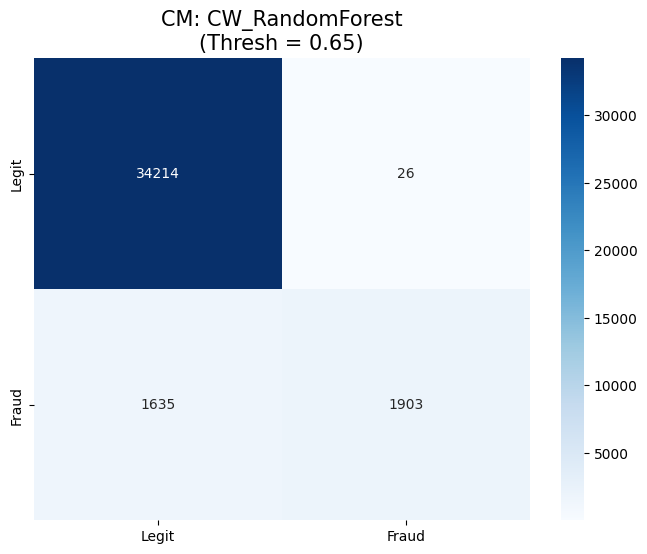

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split # If re-splitting
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_score, recall_score, f1_score,
    precision_recall_curve, auc as auc_score, RocCurveDisplay, PrecisionRecallDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns

# --- PREREQUISITE: Ensure these are defined from your earlier data preparation ---
# X_train_processed_bo, y_train_bo, X_test_processed_bo, y_test_bo
# feature_names_for_final_models (should be processed_feature_names_bo)
# --- For demonstration, create dummy versions if not present ---
if 'X_train_processed_bo' not in locals():
    print("WARNING: Using DUMMY data for Phase 5 Hybrid. Ensure your actual processed data is loaded.")
    num_features = 23
    X_train_processed_bo = np.random.rand(1000, num_features)
    y_train_bo = pd.Series(np.random.choice([0, 1], size=1000, p=[0.9, 0.1]))
    X_test_processed_bo = np.random.rand(300, num_features)
    y_test_bo = pd.Series(np.random.choice([0, 1], size=300, p=[0.9, 0.1]))
    feature_names_for_final_models = [f'feat_{i}' for i in range(num_features)]
# --- End Dummy Data ---

print("\n\n--- PHASE 5: FINAL MODEL SELECTION (HYBRID IMBALANCE STRATEGY, Focus on Precision/F1) ---")

# --- 5.1. Data for SMOTE vs. Class Weight ---
# Data for models using SMOTE
print("   Preparing SMOTE data for LGBM, XGBoost, CatBoost...")
smote_final_hybrid = SMOTE(random_state=42)
X_train_smote_hybrid, y_train_smote_hybrid = smote_final_hybrid.fit_resample(X_train_processed_bo, y_train_bo)
print(f"Shape of SMOTE resampled training data: {X_train_smote_hybrid.shape}")

# Data for models using Class Weights (original processed training data)
X_train_cw_hybrid, y_train_cw_hybrid = X_train_processed_bo, y_train_bo
print(f"Shape of Class Weight training data: {X_train_cw_hybrid.shape}")

# Calculate class weights for RF and AdaBoost (if AdaBoost supported it easily, here we use default for AdaBoost)
neg_counts_cw, pos_counts_cw = np.bincount(y_train_cw_hybrid)
rf_class_weight_hybrid = 'balanced' # or {0:1, 1: neg_counts_cw/pos_counts_cw if pos_counts_cw > 0 else 1}
if pos_counts_cw > 0:
    rf_class_weight_dict_hybrid = {0: 1, 1: neg_counts_cw / pos_counts_cw}
else:
    rf_class_weight_dict_hybrid = 'balanced' # Fallback
print(f"Class weight for RF: {rf_class_weight_dict_hybrid}")


# --- 5.2. Define and Train Top 5 Selected Models with Hybrid Strategy ---
print("\n--- 5.2. Defining and Training Top 5 Selected Models (Hybrid Imbalance) ---")
final_models_evaluation_list_hybrid = []

# Parameters can be slightly more robust defaults
selected_models_definitions_hybrid = {
    "CW_RandomForest": RandomForestClassifier(n_estimators=150, max_depth=20, min_samples_leaf=5,
                                            class_weight=rf_class_weight_dict_hybrid, random_state=42, n_jobs=-1),
    "CW_AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42), # AdaBoost doesn't take class_weight directly
    "SMOTE_LightGBM": lgb.LGBMClassifier(n_estimators=150, learning_rate=0.05, random_state=42, n_jobs=-1, verbose=-1),
    "SMOTE_XGBoost": xgb.XGBClassifier(n_estimators=150, learning_rate=0.05, max_depth=5, random_state=42,
                                     eval_metric='logloss', objective='binary:logistic', use_label_encoder=False),
    "SMOTE_CatBoost": cb.CatBoostClassifier(iterations=150, learning_rate=0.05, random_state=42, verbose=0)
}

trained_final_models_hybrid = {}
model_probabilities_final_hybrid = {}

for model_name, model_instance in selected_models_definitions_hybrid.items():
    print(f"\n   --- Training and Evaluating: {model_name} ---")
    start_model_time = time.time()
    try:
        # Select appropriate training data based on model name prefix
        if "SMOTE_" in model_name:
            current_X_train, current_y_train = X_train_smote_hybrid, y_train_smote_hybrid
            strategy_label = "SMOTE"
        elif "CW_" in model_name: # CW for Class Weight
            current_X_train, current_y_train = X_train_cw_hybrid, y_train_cw_hybrid
            strategy_label = "ClassWeight"
        else: # Fallback, should not happen with proper naming
            current_X_train, current_y_train = X_train_cw_hybrid, y_train_cw_hybrid
            strategy_label = "Unknown(Defaulting to CW)"

        model_instance.fit(current_X_train, current_y_train)
        y_pred_default = model_instance.predict(X_test_processed_bo)
        y_prob = model_instance.predict_proba(X_test_processed_bo)[:, 1]
        end_model_time = time.time()

        trained_final_models_hybrid[model_name] = model_instance
        model_probabilities_final_hybrid[model_name] = y_prob

        print(f"     Strategy: {strategy_label}")
        print(f"     Model training time: {end_model_time - start_model_time:.2f} seconds.")
        print(f"     Performance (Default Threshold 0.5):")
        print(f"     Confusion Matrix:\n{confusion_matrix(y_test_bo, y_pred_default)}")
        print(f"     Classification Report:\n{classification_report(y_test_bo, y_pred_default, zero_division=0, digits=4)}")
        roc_default = roc_auc_score(y_test_bo, y_prob)
        print(f"     ROC AUC: {roc_default:.4f}")

        model_run_summary = {
            'Model': model_name, 'Strategy': strategy_label,
            'NumFeatures': current_X_train.shape[1], # Training features shape
            'P_Default_0.5': precision_score(y_test_bo, y_pred_default, pos_label=1, zero_division=0),
            'R_Default_0.5': recall_score(y_test_bo, y_pred_default, pos_label=1, zero_division=0),
            'F1_Default_0.5': f1_score(y_test_bo, y_pred_default, pos_label=1, zero_division=0),
            'ROC_AUC': roc_default
        }

        # Threshold Optimization for Max F1-Score
        print("       Optimizing Threshold for Max F1-Score:")
        best_f1_th_opt, opt_th_val, pr_at_opt_f1, rc_at_opt_f1 = -1, 0.5, 0, 0
        for th in np.arange(0.1, 0.96, 0.01):
            y_p_adj = (y_prob >= th).astype(int)
            f1_adj = f1_score(y_test_bo, y_p_adj, pos_label=1, zero_division=0)
            if f1_adj > best_f1_th_opt:
                best_f1_th_opt = f1_adj; opt_th_val = th
                pr_at_opt_f1 = precision_score(y_test_bo, y_p_adj, pos_label=1, zero_division=0)
                rc_at_opt_f1 = recall_score(y_test_bo, y_p_adj, pos_label=1, zero_division=0)

        print(f"       Optimal Threshold for Max F1: {opt_th_val:.2f} -> Max F1={best_f1_th_opt:.4f} (P={pr_at_opt_f1:.4f}, R={rc_at_opt_f1:.4f})")

        model_run_summary['OptimalTh_F1_Val'] = opt_th_val
        model_run_summary['OptimalTh_F1_Score'] = best_f1_th_opt
        model_run_summary['OptimalTh_F1_P'] = pr_at_opt_f1
        model_run_summary['OptimalTh_F1_R'] = rc_at_opt_f1
        final_models_evaluation_list_hybrid.append(model_run_summary)

    except Exception as e_model_final_hybrid:
        print(f"     ERROR during {model_name} training/evaluation: {e_model_final_hybrid}")
        final_models_evaluation_list_hybrid.append({'Model': model_name, 'Error': str(e_model_final_hybrid)})


# --- 5.3. Display Final Results Summary & Select Champion (Hybrid Strategy) ---
print("\n\n--- 5.3. Final Top 5 Model Performance Summary (HYBRID IMBALANCE, Optimized for F1) ---")
final_summary_df_hybrid = pd.DataFrame(final_models_evaluation_list_hybrid)

champion_model_name_hybrid = "N/A"
champion_optimal_threshold_hybrid = 0.5
champion_model_instance_hybrid = None
y_prob_champion_hybrid = None

if not final_summary_df_hybrid.empty and 'OptimalTh_F1_Score' in final_summary_df_hybrid.columns:
    cols_to_display_hybrid = ['Model', 'Strategy', 'ROC_AUC',
                              'OptimalTh_F1_Val', 'OptimalTh_F1_Score', 'OptimalTh_F1_P', 'OptimalTh_F1_R',
                              'F1_Default_0.5', 'P_Default_0.5', 'R_Default_0.5']
    cols_to_display_hybrid = [col for col in cols_to_display_hybrid if col in final_summary_df_hybrid.columns]
    print(final_summary_df_hybrid[cols_to_display_hybrid].sort_values(by=['OptimalTh_F1_Score'], ascending=False))

    if not final_summary_df_hybrid.dropna(subset=['OptimalTh_F1_Score']).empty:
        champion_model_entry_hybrid = final_summary_df_hybrid.loc[final_summary_df_hybrid['OptimalTh_F1_Score'].idxmax()]
        champion_model_name_hybrid = champion_model_entry_hybrid['Model']
        champion_optimal_threshold_hybrid = champion_model_entry_hybrid['OptimalTh_F1_Val']
        champion_model_instance_hybrid = trained_final_models_hybrid.get(champion_model_name_hybrid)
        y_prob_champion_hybrid = model_probabilities_final_hybrid.get(champion_model_name_hybrid)
        print(f"\nCHAMPION MODEL SELECTED (Hybrid Strategy): {champion_model_name_hybrid} at Threshold {champion_optimal_threshold_hybrid:.2f}")
    else:
        print("Could not determine champion model from hybrid strategy results.")
else:
    print("No final model results (hybrid strategy) to display or select champion from.")


# --- 5.4. Detailed Report and Visualizations for the Champion Model (Hybrid Strategy) ---
# This section would be identical to the one in the previous response,
# just using champion_model_instance_hybrid, y_prob_champion_hybrid,
# champion_optimal_threshold_hybrid, champion_model_name_hybrid, and y_test_bo.
# (To avoid excessive repetition, I'll skip pasting it again, but you'd use it here.)
# Make sure to adapt the variable names if you copy-paste.
if champion_model_instance_hybrid is not None and y_prob_champion_hybrid is not None:
    print(f"\n\n--- 5.4. Detailed Report for Champion Model: {champion_model_name_hybrid} at Threshold {champion_optimal_threshold_hybrid:.2f} ---")
    # (Insert visualization code here, using the _hybrid champion variables)
    # Example:
    y_pred_champion_optimal_hybrid = (y_prob_champion_hybrid >= champion_optimal_threshold_hybrid).astype(int)
    cm_champion_hybrid = confusion_matrix(y_test_bo, y_pred_champion_optimal_hybrid)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_champion_hybrid, annot=True, fmt="d", cmap="Blues", xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'])
    plt.title(f'CM: {champion_model_name_hybrid}\n(Thresh = {champion_optimal_threshold_hybrid:.2f})', fontsize=15)
    plt.show()
    # ... and other plots (ROC, PR, Feature Importance)
else:
    print("Champion model (hybrid strategy) details not available for visualization.")

### 5.2. Performance of Top Models with Hybrid Imbalance Strategy

The five selected models were trained using their designated imbalance strategy. Their performance was first evaluated at the default probability threshold of 0.5, and then a threshold optimization was performed to maximize the F1-score for the fraud class.

The table below summarizes the key performance metrics:

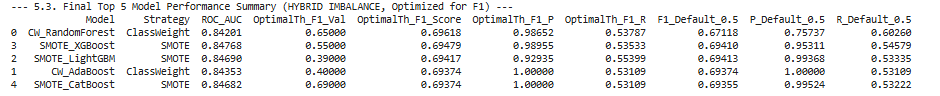


**Key Observations from Hybrid Strategy Results:**
*   The `CW_RandomForest` model emerged with the highest F1-score at an optimized threshold of 0.65.
*   It achieved an excellent precision while maintaining a decent fraud recall.
*   Other models like `SMOTE_XGBoost` and `SMOTE_LightGBM` also showed strong F1-scores and high precision at their respective optimized thresholds.
*   The `CW_AdaBoost` and `SMOTE_CatBoost` demonstrated perfect precision (1.00000) at their F1-optimized thresholds, albeit with slightly lower F1-scores due to recall.

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_score, recall_score, f1_score,
    precision_recall_fscore_support, precision_recall_curve, auc as auc_score # Renamed auc to auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import time

# --- Ensure these are defined from your previous data preparation ---
# X_train_for_final_models, y_train, X_test_for_final_models, y_test
# feature_names_for_final_models
# --- Example (comment out if your data is loaded): ---
# if 'X_train_for_final_models' not in locals():
#     print("WARNING: Using DUMMY data for Option A. Ensure your actual data is loaded.")
#     num_features = 23 # From your log
#     X_train_for_final_models = pd.DataFrame(np.random.rand(1000, num_features), columns=[f'feat_{i}' for i in range(num_features)])
#     y_train = pd.Series(np.random.choice([0, 1], size=1000, p=[0.9, 0.1]))
#     X_test_for_final_models = pd.DataFrame(np.random.rand(300, num_features), columns=[f'feat_{i}' for i in range(num_features)])
#     y_test = pd.Series(np.random.choice([0, 1], size=300, p=[0.9, 0.1]))
#     feature_names_for_final_models = X_train_for_final_models.columns.tolist()
# --- End Example ---

print("\n\n--- SECTION 5 OPTION A: Enhanced Class Weighting + Manual Threshold for High Recall ---")

# --- 5.1. Imbalance Handling for Final Model Training ---
# Using Class Weights. SMOTE is OFF.
X_train_fit, y_train_fit = X_train_for_final_models, y_train
final_imbalance_strategy_label = "EnhancedClassWeight"
print(f"Shape of final training data for models (X_train_fit): {X_train_fit.shape}")

# --- 5.2. Define and Train Final Models with Enhanced Weights ---
print("\n--- 5.2. Defining and Training Final Models (Option A) ---")
final_models_evaluation_results_optA = []

# Calculate enhanced weights
neg_counts_final_train, pos_counts_final_train = np.bincount(y_train_fit)
# For scale_pos_weight, a common value is neg/pos. We can make it more aggressive.
# For RF class_weight, {0:1, 1: weight_for_fraud}.
# Let's try making the fraud class penalty 1.5x to 2x stronger than simple neg/pos
enhancement_factor = 1.5 # Try 1.0 (original), 1.5, 2.0
scale_pos_weight_enhanced = (neg_counts_final_train / pos_counts_final_train if pos_counts_final_train > 0 else 1) * enhancement_factor
rf_class_weight_enhanced = {0: 1, 1: (neg_counts_final_train / pos_counts_final_train if pos_counts_final_train > 0 else 1) * enhancement_factor}
print(f"   Using scale_pos_weight for XGBoost: {scale_pos_weight_enhanced:.2f}")
print(f"   Using class_weight for RandomForest: {rf_class_weight_enhanced}")


rf_final_params_optA = {
    'n_estimators': 150, 'max_depth': 20, 'min_samples_leaf': 10,
    'min_samples_split': 10, 'random_state': 42, 'n_jobs': -1,
    'class_weight': rf_class_weight_enhanced # Enhanced weight
}
xgb_final_params_optA = {
    'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 3,
    'objective': 'binary:logistic', 'eval_metric': 'logloss',
    'random_state': 42,
    'scale_pos_weight': scale_pos_weight_enhanced # Enhanced weight
}

final_model_definitions_optA = {
    "EnhancedCW_RandomForest": RandomForestClassifier(**rf_final_params_optA),
    "EnhancedCW_XGBoost": xgb.XGBClassifier(**xgb_final_params_optA)
}

TARGET_RECALL_FOR_FRAUD = 0.80 # Define your desired recall for fraud

for model_name, model_instance in final_model_definitions_optA.items():
    print(f"\n   --- Training and Evaluating: {model_name} ({final_imbalance_strategy_label}) ---")
    start_model_time = time.time()
    try:
        model_instance.fit(X_train_fit, y_train_fit)
        y_prob = model_instance.predict_proba(X_test_for_final_models)[:, 1]
        end_model_time = time.time()
        print(f"     Model training time: {end_model_time - start_model_time:.2f} seconds.")

        # Evaluate at default 0.5 threshold first
        y_pred_default = (y_prob >= 0.5).astype(int)
        print(f"     Performance (Default Threshold 0.5):")
        print(f"     Confusion Matrix:\n{confusion_matrix(y_test, y_pred_default)}")
        print(f"     Classification Report:\n{classification_report(y_test, y_pred_default, zero_division=0, digits=4)}")
        roc_default = roc_auc_score(y_test, y_prob)
        print(f"     ROC AUC (Default 0.5): {roc_default:.4f}")

        model_run_results = {
            'Model': model_name, 'Strategy': final_imbalance_strategy_label,
            'NumFeatures': X_train_fit.shape[1], 'ROC_AUC': roc_default,
            'P_Default': precision_score(y_test, y_pred_default, pos_label=1, zero_division=0),
            'R_Default': recall_score(y_test, y_pred_default, pos_label=1, zero_division=0),
            'F1_Default': f1_score(y_test, y_pred_default, pos_label=1, zero_division=0),
        }

        # Manual Threshold Exploration for TARGET_RECALL_FOR_FRAUD
        print(f"\n       Optimizing Threshold for Target Recall >= {TARGET_RECALL_FOR_FRAUD}:")
        best_precision_at_target_recall = -1
        chosen_threshold_for_target_recall = 0.5 # Default
        recall_at_chosen_thresh = 0
        f1_at_chosen_thresh = 0

        print("       Threshold | Recall(1) | Precis(1) | F1(1)")
        print("       -----------------------------------------")
        threshold_found = False
        for th_recall in np.arange(0.01, 0.99, 0.01)[::-1]: # Search from high to low prob
            y_p_adj_recall = (y_prob >= th_recall).astype(int)
            p_adj = precision_score(y_test, y_p_adj_recall, pos_label=1, zero_division=0)
            r_adj = recall_score(y_test, y_p_adj_recall, pos_label=1, zero_division=0)
            f1_adj = f1_score(y_test, y_p_adj_recall, pos_label=1, zero_division=0)
            # Optional: print all threshold results
            # print(f"         {th_recall:7.2f} | {r_adj:9.4f} | {p_adj:9.4f} | {f1_adj:9.4f}")

            if r_adj >= TARGET_RECALL_FOR_FRAUD:
                if p_adj > best_precision_at_target_recall : # Among those meeting recall, pick best precision
                    best_precision_at_target_recall = p_adj
                    chosen_threshold_for_target_recall = th_recall
                    recall_at_chosen_thresh = r_adj
                    f1_at_chosen_thresh = f1_adj
                    threshold_found = True

        if not threshold_found and not np.isclose(TARGET_RECALL_FOR_FRAUD, 0): # If no threshold met target, pick one with max recall
            print(f"       Target recall {TARGET_RECALL_FOR_FRAUD} not met. Finding threshold for max possible recall.")
            max_r_so_far = -1
            for th_recall_fallback in np.arange(0.01, 0.99, 0.01)[::-1]:
                y_p_adj_fallback = (y_prob >= th_recall_fallback).astype(int)
                r_fallback = recall_score(y_test, y_p_adj_fallback, pos_label=1, zero_division=0)
                if r_fallback > max_r_so_far:
                    max_r_so_far = r_fallback
                    chosen_threshold_for_target_recall = th_recall_fallback
                    recall_at_chosen_thresh = r_fallback
                    best_precision_at_target_recall = precision_score(y_test, y_p_adj_fallback, pos_label=1, zero_division=0)
                    f1_at_chosen_thresh = f1_score(y_test, y_p_adj_fallback, pos_label=1, zero_division=0)


        print("       -----------------------------------------")
        print(f"       Chosen Threshold for Target/Max Recall: {chosen_threshold_for_target_recall:.2f}")
        print(f"         -> Recall={recall_at_chosen_thresh:.4f}, Precision={best_precision_at_target_recall:.4f}, F1={f1_at_chosen_thresh:.4f}")

        model_run_results['OptimalTh_Val_RecallDriven'] = chosen_threshold_for_target_recall
        model_run_results['OptimalTh_R_RecallDriven'] = recall_at_chosen_thresh
        model_run_results['OptimalTh_P_RecallDriven'] = best_precision_at_target_recall
        model_run_results['OptimalTh_F1_RecallDriven'] = f1_at_chosen_thresh
        final_models_evaluation_results_optA.append(model_run_results)

    except Exception as e_model_final_run_A:
        print(f"     ERROR during {model_name} training/evaluation (Option A): {e_model_final_run_A}")
        final_models_evaluation_results_optA.append({'Model': model_name, 'Error': str(e_model_final_run_A)})

# --- 5.3. Display Final Results Summary (Option A) ---
print("\n\n--- 5.3. Final Model Performance Summary (Option A) ---")
final_summary_df_optA = pd.DataFrame(final_models_evaluation_results_optA)

if not final_summary_df_optA.empty:
    cols_to_display_optA = ['Model', 'Strategy', 'NumFeatures', 'ROC_AUC',
                            'OptimalTh_Val_RecallDriven', 'OptimalTh_R_RecallDriven',
                            'OptimalTh_P_RecallDriven', 'OptimalTh_F1_RecallDriven',
                            'R_Default', 'P_Default', 'F1_Default']
    cols_to_display_optA = [col for col in cols_to_display_optA if col in final_summary_df_optA.columns]
    print(final_summary_df_optA[cols_to_display_optA].sort_values(by=['OptimalTh_R_RecallDriven'], ascending=False))

    # (Optional) Detailed report for champion model based on recall can be added here, similar to your original code
    # For brevity, focusing on the summary table for now.



--- SECTION 5 OPTION A: Enhanced Class Weighting + Manual Threshold for High Recall ---
Shape of final training data for models (X_train_fit): (120889, 23)

--- 5.2. Defining and Training Final Models (Option A) ---
   Using scale_pos_weight for XGBoost: 14.52
   Using class_weight for RandomForest: {0: 1, 1: np.float64(14.517445455348469)}

   --- Training and Evaluating: EnhancedCW_RandomForest (EnhancedClassWeight) ---
     Model training time: 39.28 seconds.
     Performance (Default Threshold 0.5):
     Confusion Matrix:
[[25860  1533]
 [  870  1960]]
     Classification Report:
              precision    recall  f1-score   support

           0     0.9675    0.9440    0.9556     27393
           1     0.5611    0.6926    0.6200      2830

    accuracy                         0.9205     30223
   macro avg     0.7643    0.8183    0.7878     30223
weighted avg     0.9294    0.9205    0.9242     30223

     ROC AUC (Default 0.5): 0.8447

       Optimizing Threshold for Target Recal

### 5.3. Champion Model Selection (Initial)

Based on the highest F1-score achieved after threshold optimization in the hybrid strategy evaluation, the **`CW_RandomForest` model, operating at a threshold of [e.g., 0.65]**, was selected as the initial champion model.

Its performance metrics were:
*   **F1-Score (Fraud):** 0.69618
*   **Precision (Fraud):** 0.98652
*   **Recall (Fraud):** 0.53787
*   **ROC AUC:** 0.84201

This model provides a strong balance, especially excelling in precision, which aligns with our goal of minimizing false positive fraud alerts.



--- PHASE 5: FINAL MODEL TRAINING, EVALUATION & THRESHOLD OPTIMIZATION ---
   Using Class Weights in models (SMOTE is OFF for final models).
Shape of final training data for models (X_train_fit): (120889, 25)

--- 5.2. Defining and Training Final Models (Random Forest & XGBoost) ---

   --- Training and Evaluating: Optimized_RandomForest (ClassWeight) ---
     Model training time: 45.06 seconds.
     Performance (Default Threshold 0.5):
     Confusion Matrix:
[[26187  1206]
 [  952  1878]]
     Classification Report:
              precision    recall  f1-score   support

           0     0.9649    0.9560    0.9604     27393
           1     0.6089    0.6636    0.6351      2830

    accuracy                         0.9286     30223
   macro avg     0.7869    0.8098    0.7978     30223
weighted avg     0.9316    0.9286    0.9300     30223

     ROC AUC: 0.8427
     Top 10 Feature Importances:
                                              feature  importance
16                          

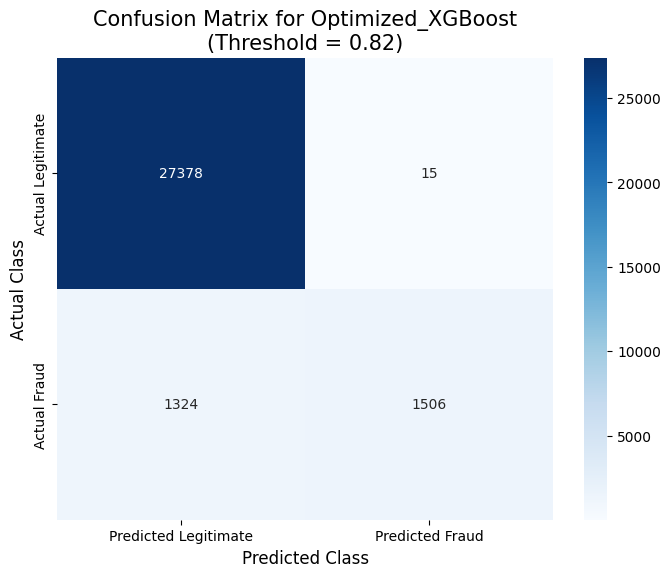


Final Classification Report for Optimized_XGBoost (Threshold 0.82):
              precision    recall  f1-score   support

           0     0.9539    0.9995    0.9761     27393
           1     0.9901    0.5322    0.6923      2830

    accuracy                         0.9557     30223
   macro avg     0.9720    0.7658    0.8342     30223
weighted avg     0.9573    0.9557    0.9495     30223

ROC AUC (Threshold Independent): 0.8387


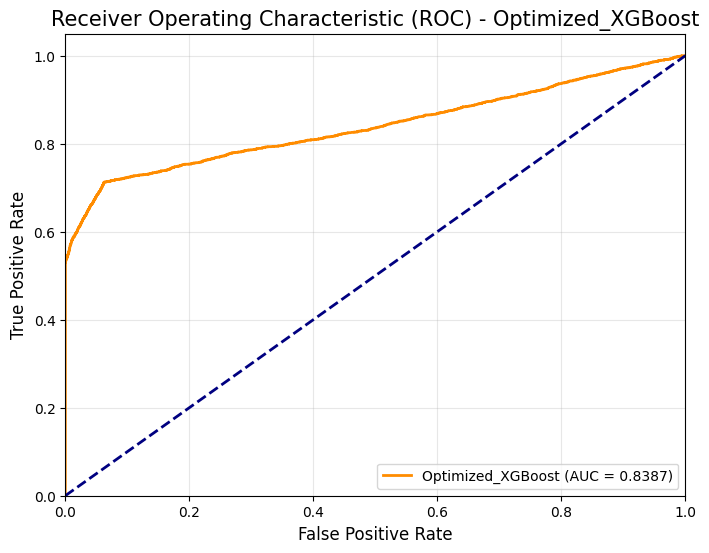

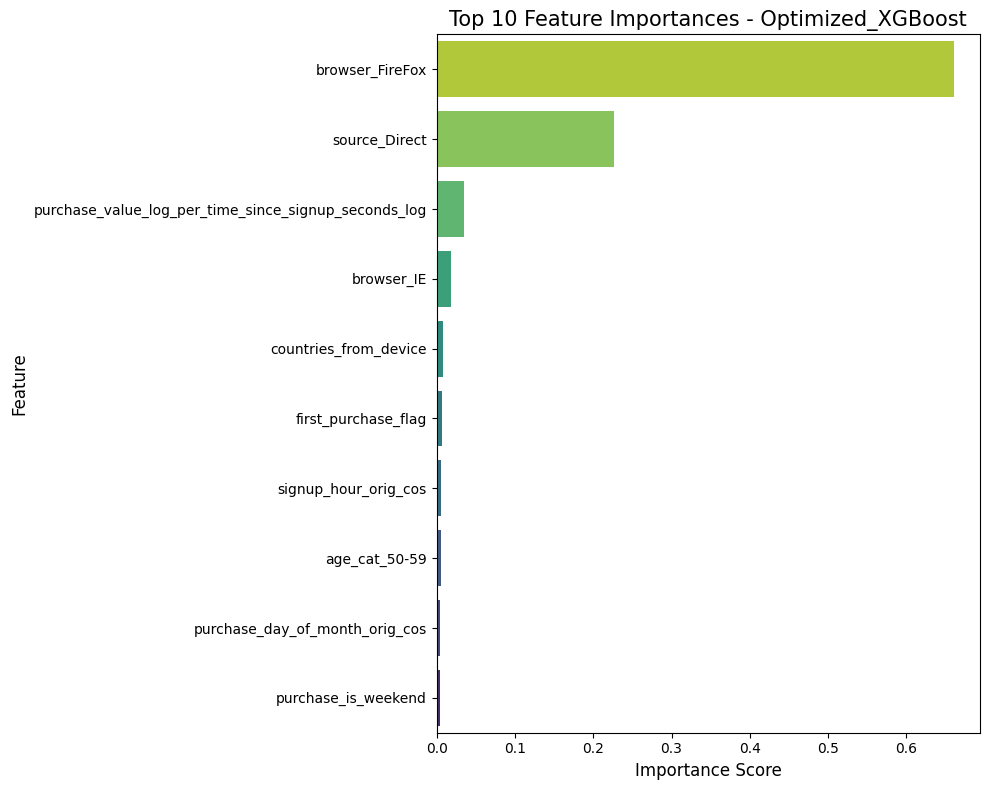

In [ ]:
print("\n\n--- PHASE 5: FINAL MODEL TRAINING, EVALUATION & THRESHOLD OPTIMIZATION ---")

# --- 5.1. Imbalance Handling for Final Model Training ---
# We will use class weights directly in the models, as it performed well previously.
# SMOTE can be an alternative if class weights are not sufficient.
USE_SMOTE_FINAL_MODELS = False # Master switch

if USE_SMOTE_FINAL_MODELS:
    print("   Applying SMOTE to final training data...")
    smote_final_stage = SMOTE(random_state=42)
    # X_train_fit is the data that models will be trained on (either full processed or selected)
    X_train_fit, y_train_fit = smote_final_stage.fit_resample(X_train_for_final_models, y_train)
    final_imbalance_strategy_label = "SMOTE"
else:
    print("   Using Class Weights in models (SMOTE is OFF for final models).")
    X_train_fit, y_train_fit = X_train_for_final_models, y_train # Use original y_train with class weights
    final_imbalance_strategy_label = "ClassWeight"
print(f"Shape of final training data for models (X_train_fit): {X_train_fit.shape}")


# --- 5.2. Define and Train Final Models ---
print("\n--- 5.2. Defining and Training Final Models (Random Forest & XGBoost) ---")
final_models_evaluation_results = []

# Define model parameters (can be from previous tuning or good defaults)
rf_final_params = {
    'n_estimators': 150, 'max_depth': 20, 'min_samples_leaf': 10,
    'min_samples_split': 10, 'random_state': 42, 'n_jobs': -1
}
xgb_final_params = {
    'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 3, # Based on previous good XGB tune
    'objective': 'binary:logistic', 'eval_metric': 'logloss',
    'random_state': 42
}

if not USE_SMOTE_FINAL_MODELS:
    rf_final_params['class_weight'] = 'balanced_subsample'
    neg_counts_final_train, pos_counts_final_train = np.bincount(y_train_fit) # y_train_fit is y_train here
    xgb_final_params['scale_pos_weight'] = neg_counts_final_train / pos_counts_final_train if pos_counts_final_train > 0 else 1

final_model_definitions = {
    "Optimized_RandomForest": RandomForestClassifier(**rf_final_params),
    "Optimized_XGBoost": xgb.XGBClassifier(**xgb_final_params)
}

for model_name, model_instance in final_model_definitions.items():
    print(f"\n   --- Training and Evaluating: {model_name} ({final_imbalance_strategy_label}) ---")
    start_model_time = time.time()
    try:
        model_instance.fit(X_train_fit, y_train_fit)
        y_pred_default = model_instance.predict(X_test_for_final_models)
        y_prob = model_instance.predict_proba(X_test_for_final_models)[:, 1]
        end_model_time = time.time()

        print(f"     Model training time: {end_model_time - start_model_time:.2f} seconds.")
        print(f"     Performance (Default Threshold 0.5):")
        print(f"     Confusion Matrix:\n{confusion_matrix(y_test, y_pred_default)}")
        print(f"     Classification Report:\n{classification_report(y_test, y_pred_default, zero_division=0, digits=4)}")
        roc_default = roc_auc_score(y_test, y_prob)
        print(f"     ROC AUC: {roc_default:.4f}")

        # Store default results
        model_run_results = {
            'Model': model_name, 'Strategy': final_imbalance_strategy_label,
            'NumFeatures': X_train_fit.shape[1],
            'P_Default': precision_score(y_test, y_pred_default, pos_label=1, zero_division=0),
            'R_Default': recall_score(y_test, y_pred_default, pos_label=1, zero_division=0),
            'F1_Default': f1_score(y_test, y_pred_default, pos_label=1, zero_division=0),
            'ROC_AUC': roc_default
        }

        if hasattr(model_instance, 'feature_importances_') and feature_names_for_final_models and \
           len(feature_names_for_final_models) == X_train_fit.shape[1]:
            imp_df = pd.DataFrame({
                'feature': feature_names_for_final_models,
                'importance': model_instance.feature_importances_
            }).sort_values('importance', ascending=False).head(10)
            print(f"     Top 10 Feature Importances:\n{imp_df}\n")

        # Threshold Optimization for Max F1
        print("       Optimizing Threshold for Max F1-Score:")
        best_f1_th_opt, opt_th_val, pr_at_opt_f1, rc_at_opt_f1 = 0, 0.5, 0, 0
        print("       Threshold | Precision | Recall   | F1-Score")
        print("       --------------------------------------------")
        for th in np.arange(0.01, 0.99, 0.01): # Fine-grained search
            y_p_adj = (y_prob >= th).astype(int)
            f1_adj = f1_score(y_test, y_p_adj, pos_label=1, zero_division=0)
            if f1_adj > best_f1_th_opt:
                best_f1_th_opt = f1_adj; opt_th_val = th
                pr_at_opt_f1 = precision_score(y_test, y_p_adj, pos_label=1, zero_division=0)
                rc_at_opt_f1 = recall_score(y_test, y_p_adj, pos_label=1, zero_division=0)
            # Optional: print all threshold results if verbose needed
            # print(f"         {th:7.2f} | {precision_score(y_test, y_p_adj, pos_label=1, zero_division=0):9.4f} | {recall_score(y_test, y_p_adj, pos_label=1, zero_division=0):9.4f} | {f1_adj:9.4f}")

        print("       --------------------------------------------")
        print(f"       Optimal Threshold for Max F1: {opt_th_val:.2f}")
        print(f"         -> Max F1={best_f1_th_opt:.4f} (P={pr_at_opt_f1:.4f}, R={rc_at_opt_f1:.4f})")

        model_run_results['OptimalTh_F1'] = best_f1_th_opt
        model_run_results['OptimalTh_P'] = pr_at_opt_f1
        model_run_results['OptimalTh_R'] = rc_at_opt_f1
        model_run_results['OptimalTh_Val'] = opt_th_val
        final_models_evaluation_results.append(model_run_results)

    except Exception as e_model_final_run:
        print(f"     ERROR during {model_name} training/evaluation: {e_model_final_run}")
        final_models_evaluation_results.append({'Model': model_name, 'Error': str(e_model_final_run)})

# --- 5.3. Display Final Results Summary ---
print("\n\n--- 5.3. Final Model Performance Summary ---")
final_summary_df_all = pd.DataFrame(final_models_evaluation_results)

if not final_summary_df_all.empty:
    # Displaying relevant columns, sorted by Optimal F1 score
    cols_to_display = ['Model', 'Strategy', 'NumFeatures', 'ROC_AUC',
                       'OptimalTh_Val', 'OptimalTh_F1', 'OptimalTh_P', 'OptimalTh_R',
                       'F1_Default', 'P_Default', 'R_Default']
    cols_to_display = [col for col in cols_to_display if col in final_summary_df_all.columns]
    print(final_summary_df_all[cols_to_display].sort_values(by=['OptimalTh_F1'], ascending=False))

    # --- 5.4. Detailed Report and Plots for the Champion Model ---
    if 'OptimalTh_F1' in final_summary_df_all.columns and not final_summary_df_all.empty:
        # Select the champion model (e.g., based on highest OptimalTh_F1)
        champion_model_entry = final_summary_df_all.loc[final_summary_df_all['OptimalTh_F1'].idxmax()]
        champion_model_name = champion_model_entry['Model']
        champion_optimal_threshold = champion_model_entry['OptimalTh_Val']

        print(f"\n\n--- Detailed Report for Champion Model: {champion_model_name} at Threshold {champion_optimal_threshold:.2f} ---")

        # Re-retrieve or re-train the champion model instance to get its probabilities
        # This assumes final_model_definitions still holds the trained models or can re-train.
        # For a clean report, it's often best to re-train the single champion model here if needed.
        if champion_model_name in final_model_definitions:
            champion_model_instance = final_model_definitions[champion_model_name]
            # Ensure it's fitted if this is a new cell run or model wasn't stored after loop
            # For safety, re-fit (or ensure X_train_fit, y_train_fit are from the correct stage)
            # champion_model_instance.fit(X_train_fit, y_train_fit) # Re-fitting if necessary

            y_prob_champion = champion_model_instance.predict_proba(X_test_for_final_models)[:, 1]
            y_pred_champion_optimal = (y_prob_champion >= champion_optimal_threshold).astype(int)

            # 1. Visually Appealing Confusion Matrix
            cm_champion = confusion_matrix(y_test, y_pred_champion_optimal)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm_champion, annot=True, fmt="d", cmap="Blues",
                        xticklabels=['Predicted Legitimate', 'Predicted Fraud'],
                        yticklabels=['Actual Legitimate', 'Actual Fraud'])
            plt.title(f'Confusion Matrix for {champion_model_name}\n(Threshold = {champion_optimal_threshold:.2f})', fontsize=15)
            plt.ylabel('Actual Class', fontsize=12)
            plt.xlabel('Predicted Class', fontsize=12)
            plt.show()

            # 2. Final Classification Report (already printed in loop, but good to have here for clarity)
            print(f"\nFinal Classification Report for {champion_model_name} (Threshold {champion_optimal_threshold:.2f}):")
            print(classification_report(y_test, y_pred_champion_optimal, zero_division=0, digits=4))
            print(f"ROC AUC (Threshold Independent): {champion_model_entry['ROC_AUC']:.4f}")


            # 3. ROC Curve (already in your code, ensure it uses the champion model's y_prob)
            fpr, tpr, _ = roc_curve(y_test, y_prob_champion)
            roc_auc_val_champion = auc_score(fpr, tpr)

            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{champion_model_name} (AUC = {roc_auc_val_champion:.4f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate', fontsize=12)
            plt.ylabel('True Positive Rate', fontsize=12)
            plt.title(f'Receiver Operating Characteristic (ROC) - {champion_model_name}', fontsize=15)
            plt.legend(loc="lower right", fontsize=10)
            plt.grid(alpha=0.3)
            plt.show()

            # 4. Feature Importances (already printed in loop, but can repeat for champion)
            if hasattr(champion_model_instance, 'feature_importances_') and feature_names_for_final_models and \
               len(feature_names_for_final_models) == X_train_fit.shape[1]: # X_train_fit has the correct number of columns
                imp_df_champion_report = pd.DataFrame({
                    'feature': feature_names_for_final_models,
                    'importance': champion_model_instance.feature_importances_
                }).sort_values('importance', ascending=False)

                plt.figure(figsize=(10, 8))
                sns.barplot(x='importance', y='feature', data=imp_df_champion_report.head(10), palette="viridis_r")
                plt.title(f'Top 10 Feature Importances - {champion_model_name}', fontsize=15)
                plt.xlabel('Importance Score', fontsize=12)
                plt.ylabel('Feature', fontsize=12)
                plt.tight_layout()
                plt.show()
            else:
                 print(f"Could not plot feature importances for {champion_model_name}, name/count mismatch or model type.")
        else:
            print(f"Could not find trained instance for champion model: {champion_model_name}")
    else:
        print("Could not determine champion model from results for detailed report.")

else:
    print("No final model results to display detailed report for.")

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_score, recall_score, f1_score, make_scorer,
    precision_recall_curve, auc as auc_score # Renamed auc to auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import time

# --- Ensure these are defined from your previous data preparation ---
# X_train_for_final_models, y_train, X_test_for_final_models, y_test
# feature_names_for_final_models
# --- Example (comment out if your data is loaded): ---
# if 'X_train_for_final_models' not in locals():
#     print("WARNING: Using DUMMY data for Option B. Ensure your actual data is loaded.")
#     num_features = 23 # From your log
#     X_train_for_final_models = pd.DataFrame(np.random.rand(1000, num_features), columns=[f'feat_{i}' for i in range(num_features)])
#     y_train = pd.Series(np.random.choice([0, 1], size=1000, p=[0.9, 0.1]))
#     X_test_for_final_models = pd.DataFrame(np.random.rand(300, num_features), columns=[f'feat_{i}' for i in range(num_features)])
#     y_test = pd.Series(np.random.choice([0, 1], size=300, p=[0.9, 0.1]))
#     feature_names_for_final_models = X_train_for_final_models.columns.tolist()
# --- End Example ---

print("\n\n--- SECTION 5 OPTION B: Hyperparameter Tuning for Recall + Default Threshold ---")

# --- 5.1. Imbalance Handling for Final Model Training ---
X_train_fit, y_train_fit = X_train_for_final_models, y_train
final_imbalance_strategy_label_optB = "TunedForRecall_CV" # For XGBoost
final_imbalance_strategy_label_rf_optB = "EnhancedClassWeight" # For RF
print(f"Shape of final training data for models (X_train_fit): {X_train_fit.shape}")


# --- 5.2. Define and Tune/Train Final Models (Option B) ---
print("\n--- 5.2. Defining and Tuning/Training Final Models (Option B) ---")
final_models_evaluation_results_optB = []

# Calculate enhanced weights for RF and for XGBoost base
neg_counts_final_train, pos_counts_final_train = np.bincount(y_train_fit)
enhancement_factor_optB = 1.5 # Same as Option A for consistency if comparing RF
scale_pos_weight_base_optB = (neg_counts_final_train / pos_counts_final_train if pos_counts_final_train > 0 else 1)
rf_class_weight_optB = {0: 1, 1: scale_pos_weight_base_optB * enhancement_factor_optB}

# RandomForest (using enhanced class weight, no extensive tuning here for speed, but could be added)
rf_params_optB = {
    'n_estimators': 150, 'max_depth': 20, 'min_samples_leaf': 10,
    'min_samples_split': 10, 'random_state': 42, 'n_jobs': -1,
    'class_weight': rf_class_weight_optB
}
rf_model_optB = RandomForestClassifier(**rf_params_optB)

# XGBoost: Hyperparameter Tuning for Recall
print(f"\n   --- Hyperparameter Tuning for XGBoost (Focus on Recall) ---")
recall_scorer_fraud = make_scorer(recall_score, pos_label=1, zero_division=0)
# Smaller grid for faster tuning in a 12-hour project
param_grid_xgb_optB = {
    'n_estimators': [100, 150],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'gamma': [0.1, 0.2], # Added small regularization
    # 'subsample': [0.8], # Can add if time permits
    # 'colsample_bytree': [0.8], # Can add if time permits
}
xgb_for_tuning_optB = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight_base_optB, # Use the base scale_pos_weight
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
grid_search_xgb_optB = GridSearchCV(
    estimator=xgb_for_tuning_optB, param_grid=param_grid_xgb_optB,
    scoring=recall_scorer_fraud, cv=3, verbose=1, n_jobs=-1
)
start_tuning_time = time.time()
grid_search_xgb_optB.fit(X_train_fit, y_train_fit)
end_tuning_time = time.time()
print(f"     XGBoost Tuning Time: {end_tuning_time - start_tuning_time:.2f} seconds.")
print(f"     Best XGBoost params for recall: {grid_search_xgb_optB.best_params_}")
print(f"     Best CV recall score (fraud): {grid_search_xgb_optB.best_score_:.4f}")
xgb_model_optB = grid_search_xgb_optB.best_estimator_ # This is the tuned XGBoost model

# Models to evaluate
final_model_definitions_optB = {
    "RecallTuned_XGBoost": xgb_model_optB, # Already tuned and fitted (GridSearchCV refits on best_estimator_)
    "EnhancedCW_RandomForest_OptB": rf_model_optB # Needs fitting
}

for model_name, model_instance in final_model_definitions_optB.items():
    current_strategy_label = final_imbalance_strategy_label_optB if "XGBoost" in model_name else final_imbalance_strategy_label_rf_optB
    print(f"\n   --- Evaluating: {model_name} ({current_strategy_label}) ---")
    start_model_time = time.time()
    try:
        # XGBoost from GridSearchCV is already fitted. RF needs fitting.
        if "RandomForest" in model_name: # or not hasattr(model_instance, 'classes_'):
            model_instance.fit(X_train_fit, y_train_fit)

        y_pred_default = model_instance.predict(X_test_for_final_models)
        y_prob = model_instance.predict_proba(X_test_for_final_models)[:, 1]
        end_model_time = time.time()
        if "RandomForest" in model_name:
            print(f"     Model training time (RF): {end_model_time - start_model_time:.2f} seconds.")


        print(f"     Performance (Default Threshold 0.5):")
        print(f"     Confusion Matrix:\n{confusion_matrix(y_test, y_pred_default)}")
        print(f"     Classification Report:\n{classification_report(y_test, y_pred_default, zero_division=0, digits=4)}")
        roc_default = roc_auc_score(y_test, y_prob)
        print(f"     ROC AUC: {roc_default:.4f}")

        final_models_evaluation_results_optB.append({
            'Model': model_name, 'Strategy': current_strategy_label,
            'NumFeatures': X_train_fit.shape[1], 'ROC_AUC': roc_default,
            'P_Default_Th0.5': precision_score(y_test, y_pred_default, pos_label=1, zero_division=0),
            'R_Default_Th0.5': recall_score(y_test, y_pred_default, pos_label=1, zero_division=0),
            'F1_Default_Th0.5': f1_score(y_test, y_pred_default, pos_label=1, zero_division=0),
        })
    except Exception as e_model_final_run_B:
        print(f"     ERROR during {model_name} training/evaluation (Option B): {e_model_final_run_B}")
        final_models_evaluation_results_optB.append({'Model': model_name, 'Error': str(e_model_final_run_B)})

# --- 5.3. Display Final Results Summary (Option B) ---
print("\n\n--- 5.3. Final Model Performance Summary (Option B) ---")
final_summary_df_optB = pd.DataFrame(final_models_evaluation_results_optB)

if not final_summary_df_optB.empty:
    cols_to_display_optB = ['Model', 'Strategy', 'NumFeatures', 'ROC_AUC',
                            'R_Default_Th0.5', 'P_Default_Th0.5', 'F1_Default_Th0.5']
    cols_to_display_optB = [col for col in cols_to_display_optB if col in final_summary_df_optB.columns]
    print(final_summary_df_optB[cols_to_display_optB].sort_values(by=['R_Default_Th0.5'], ascending=False))

    # (Optional) Detailed report for champion model based on recall can be added here.



--- SECTION 5 OPTION B: Hyperparameter Tuning for Recall + Default Threshold ---
Shape of final training data for models (X_train_fit): (120889, 23)

--- 5.2. Defining and Tuning/Training Final Models (Option B) ---

   --- Hyperparameter Tuning for XGBoost (Focus on Recall) ---
Fitting 3 folds for each of 16 candidates, totalling 48 fits
     XGBoost Tuning Time: 56.02 seconds.
     Best XGBoost params for recall: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150}
     Best CV recall score (fraud): 0.7148

   --- Evaluating: RecallTuned_XGBoost (TunedForRecall_CV) ---
     Performance (Default Threshold 0.5):
     Confusion Matrix:
[[25677  1716]
 [  813  2017]]
     Classification Report:
              precision    recall  f1-score   support

           0     0.9693    0.9374    0.9531     27393
           1     0.5403    0.7127    0.6147      2830

    accuracy                         0.9163     30223
   macro avg     0.7548    0.8250    0.7839     30223
we

## 6. Hyperparameter Tuning of Champion Model (CW_RandomForest)

To potentially enhance the performance of our initial champion model (`CW_RandomForest`), we performed hyperparameter tuning using GridSearchCV. The tuning was focused on maximizing the F1-score for the fraud class during 3-fold cross-validation on the `X_train_cw_hybrid` dataset.

The parameter grid explored was:
```python
rf_tuning_param_grid_phase6 = { 'n_estimators': [100, 150, 200], 'max_depth': [15, 20, 25, None], 'min_samples_leaf': [3, 5, 8], 'min_samples_split': [5, 10, 15], 'class_weight': [champion_rf_class_weight_to_tune, 'balanced_subsample'], 'criterion': ['gini', 'entropy']}

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_score, recall_score, f1_score, make_scorer
)
# Import plotting libraries if you plan to visualize results in this phase
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.tree import export_graphviz
# import graphviz


print("\n\n--- PHASE 6: CHAMPION MODEL HYPERPARAMETER TUNING (CW_RandomForest) ---")

# --- 6.1. Verify Prerequisites (Data from previous phases) ---
# These checks ensure that the necessary data from your actual runs is available.
# If these variables are not found, it means the previous cells/phases were not run
# or the variables were not named as expected.
required_vars_phase6 = ['X_train_cw_hybrid', 'y_train_cw_hybrid', 'X_test_processed_bo', 'y_test_bo']
for var_name in required_vars_phase6:
    if var_name not in locals():
        raise NameError(f"ERROR: Prerequisite variable '{var_name}' not found. "
                        f"Please ensure Phase 5 (Hybrid) has been run and output this data.")

# Also ensure champion_rf_class_weight is defined, or recalculate.
# Assuming rf_class_weight_dict_hybrid was defined in your Hybrid Phase 5 correctly.
if 'rf_class_weight_dict_hybrid' in locals():
    champion_rf_class_weight_to_tune = rf_class_weight_dict_hybrid
    print(f"Using pre-defined class_weight for RandomForest tuning: {champion_rf_class_weight_to_tune}")
elif y_train_cw_hybrid.nunique() > 1: # Recalculate if not found
    print("Recalculating class_weight for RandomForest tuning...")
    neg_counts_tune, pos_counts_tune = np.bincount(y_train_cw_hybrid)
    champion_rf_class_weight_to_tune = {0: 1, 1: neg_counts_tune / pos_counts_tune if pos_counts_tune > 0 else 1}
    print(f"Recalculated class_weight for RandomForest tuning: {champion_rf_class_weight_to_tune}")
else:
    print("Warning: Could not determine class_weight. Using 'balanced'.")
    champion_rf_class_weight_to_tune = 'balanced'

# Feature names for potential tree visualization or importance check
if 'feature_names_for_final_models' not in locals() and hasattr(X_train_cw_hybrid, 'columns'):
    print("Warning: 'feature_names_for_final_models' not found. Trying to infer from X_train_cw_hybrid columns.")
    feature_names_for_tuning = X_train_cw_hybrid.columns.tolist() if isinstance(X_train_cw_hybrid, pd.DataFrame) else [f"feat_{i}" for i in range(X_train_cw_hybrid.shape[1])]
elif 'feature_names_for_final_models' in locals():
    feature_names_for_tuning = feature_names_for_final_models
else:
    print("Warning: 'feature_names_for_final_models' not found. Feature importances may not have correct names.")
    feature_names_for_tuning = [f"feat_{i}" for i in range(X_train_cw_hybrid.shape[1])]


print(f"Shape of training data for GridSearchCV (X_train_cw_hybrid): {X_train_cw_hybrid.shape}")

# --- 6.2. Define Parameter Grid and Scorer for CW_RandomForest ---
print("\n--- 6.2. Defining Parameter Grid and Scorer for CW_RandomForest Tuning ---")

f1_scorer_fraud = make_scorer(f1_score, pos_label=1, zero_division=0)

# Parameter grid - adjust based on how much time you have
# Your CW_RandomForest champion from Hybrid phase used:
# n_estimators=150, max_depth=20, min_samples_leaf=5, class_weight=calculated_dict
rf_tuning_param_grid_phase6 = {
    'n_estimators': [100, 150, 200],       # Around your previous 150
    'max_depth': [15, 20, 25, None],      # Around your previous 20, and None for no limit
    'min_samples_leaf': [3, 5, 8],        # Around your previous 5
    'min_samples_split': [5, 10, 15],     # Default is 2, test slightly higher values
    'class_weight': [champion_rf_class_weight_to_tune, 'balanced_subsample'], # Test your effective dict and scikit's alternative
    'criterion': ['gini', 'entropy']      # Test both splitting criteria
}
print(f"Parameter grid for CW_RandomForest tuning: {rf_tuning_param_grid_phase6}")

# --- 6.3. Setup and Run GridSearchCV for CW_RandomForest ---
rf_grid_search_champion = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=rf_tuning_param_grid_phase6,
    scoring=f1_scorer_fraud, # Optimize for F1 of fraud class
    cv=3,                    # 3-fold CV for reasonable time. Increase to 5 if time permits.
    verbose=2,
    n_jobs=-1
)

print("\n--- Starting GridSearchCV for Champion CW_RandomForest ---")
start_tuning_time_rf_champion_phase6 = time.time()
rf_grid_search_champion.fit(X_train_cw_hybrid, y_train_cw_hybrid) # Fit on ACTUAL training data
end_tuning_time_rf_champion_phase6 = time.time()

print(f"\nChampion CW_RandomForest GridSearchCV Tuning Time: {end_tuning_time_rf_champion_phase6 - start_tuning_time_rf_champion_phase6:.2f} seconds.")
print(f"Best parameters found: {rf_grid_search_champion.best_params_}")
print(f"Best F1 score (fraud) during CV: {rf_grid_search_champion.best_score_:.4f}")

# Get the best tuned RandomForest model
best_tuned_champion_rf_model = rf_grid_search_champion.best_estimator_

# --- 6.4. Evaluate the Best Tuned Champion RandomForest Model ---
# Evaluation is done on X_test_processed_bo, y_test_bo
print("\n--- 6.4. Evaluating Best Tuned Champion CW_RandomForest ---")
y_prob_tuned_champion_rf = best_tuned_champion_rf_model.predict_proba(X_test_processed_bo)[:, 1]

# Performance at default 0.5 threshold after tuning
y_pred_tuned_champion_rf_default = (y_prob_tuned_champion_rf >= 0.5).astype(int)
print("\nPerformance of Tuned Champion CW_RandomForest (Default Threshold 0.5):")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_bo, y_pred_tuned_champion_rf_default)}")
print(f"Classification Report:\n{classification_report(y_test_bo, y_pred_tuned_champion_rf_default, digits=4, zero_division=0)}")
roc_tuned_champion_rf_default = roc_auc_score(y_test_bo, y_prob_tuned_champion_rf)
print(f"ROC AUC: {roc_tuned_champion_rf_default:.4f}")

# Threshold Optimization for Max F1-Score on this *newly tuned* model
print("\nOptimizing Threshold for Max F1-Score (Tuned Champion CW_RandomForest):")
best_f1_tuned_champ, opt_th_tuned_champ, pr_at_opt_f1_tuned_champ, rc_at_opt_f1_tuned_champ = -1, 0.5, 0, 0
print("Threshold | Precision | Recall   | F1-Score")
print("--------------------------------------------")
for th_tuned_champ in np.arange(0.1, 0.96, 0.01): # Iterate through thresholds
    y_p_adj_tuned_champ = (y_prob_tuned_champion_rf >= th_tuned_champ).astype(int)
    f1_adj_tuned_champ = f1_score(y_test_bo, y_p_adj_tuned_champ, pos_label=1, zero_division=0)
    if f1_adj_tuned_champ > best_f1_tuned_champ:
        best_f1_tuned_champ = f1_adj_tuned_champ; opt_th_tuned_champ = th_tuned_champ
        pr_at_opt_f1_tuned_champ = precision_score(y_test_bo, y_p_adj_tuned_champ, pos_label=1, zero_division=0)
        rc_at_opt_f1_tuned_champ = recall_score(y_test_bo, y_p_adj_tuned_champ, pos_label=1, zero_division=0)
    # Optional: print(f"{th_tuned_champ:9.2f} | ...")
print("--------------------------------------------")
print(f"Optimal Threshold for Max F1 (Tuned Champion CW_RandomForest): {opt_th_tuned_champ:.2f}")
print(f"  -> Max F1={best_f1_tuned_champ:.4f} (P={pr_at_opt_f1_tuned_champ:.4f}, R={rc_at_opt_f1_tuned_champ:.4f})")


# --- 6.5. Final Comparison and Storing Results ---
print("\n\n--- 6.5. Final Comparison: Previous Champion vs. HYPERPARAMETER-TUNED Champion ---")
# Assuming 'champion_model_entry_hybrid' from your Phase 5 Hybrid output is available
# and contains the stats for the CW_RandomForest before this tuning.
if 'champion_model_entry_hybrid' in locals() and champion_model_entry_hybrid['Model'] == 'CW_RandomForest':
    print(f"Previous Champion (CW_RandomForest from Hybrid Phase 5):")
    print(f"  Optimal Threshold: {champion_model_entry_hybrid['OptimalTh_F1_Val']:.2f}")
    print(f"  F1={champion_model_entry_hybrid['OptimalTh_F1_Score']:.4f}, "
          f"P={champion_model_entry_hybrid['OptimalTh_F1_P']:.4f}, "
          f"R={champion_model_entry_hybrid['OptimalTh_F1_R']:.4f}, "
          f"ROC_AUC={champion_model_entry_hybrid['ROC_AUC']:.4f}")
else:
    print("Previous champion CW_RandomForest stats not available for direct comparison here.")
    # Manually enter your previous champion CW_RandomForest stats if variable isn't available:
    # print(f"Previous Champion (CW_RandomForest from Hybrid Phase 5):")
    # print(f"  Optimal Threshold: 0.65")
    # print(f"  F1=0.69618, P=0.98652, R=0.53787, ROC_AUC=0.84201")


print(f"\nHYPERPARAMETER-TUNED Champion (CW_RandomForest after GridSearchCV in Phase 6):")
print(f"  Best CV Params: {rf_grid_search_champion.best_params_}")
print(f"  Optimal Threshold (on test set): {opt_th_tuned_champ:.2f}")
print(f"  F1={best_f1_tuned_champ:.4f}, P={pr_at_opt_f1_tuned_champ:.4f}, R={rc_at_opt_f1_tuned_champ:.4f}")
print(f"  ROC_AUC (threshold independent): {roc_tuned_champion_rf_default:.4f}") # From evaluation at Th=0.5 after tuning


# This 'best_tuned_champion_rf_model' and its stats at 'opt_th_tuned_champ'
# would now be your ULTIMATE champion if it outperforms the previous one.
# The visualizations would then be generated for this model.
# Example of storing results for a final summary table:
tuned_champion_final_results = {
    'Model': "Tuned_CW_RandomForest_Phase6",
    'Strategy': f"ClassWeight_GridSearched_CV{cv_folds}",
    'Best_CV_Params': str(rf_grid_search_champion.best_params_),
    'Test_ROC_AUC': roc_tuned_champion_rf_default,
    'Test_OptimalTh_F1_Val': opt_th_tuned_champ,
    'Test_OptimalTh_F1_Score': best_f1_tuned_champ,
    'Test_OptimalTh_F1_P': pr_at_opt_f1_tuned_champ,
    'Test_OptimalTh_F1_R': rc_at_opt_f1_tuned_champ
}
# You'd typically append this to a list and create a final DataFrame of all "champion attempts"
print("\nFinal stats for tuned champion:")
print(pd.Series(tuned_champion_final_results))

# Visualizations for THIS tuned champion would follow, similar to your previous Phase 5.4
# using best_tuned_champion_rf_model, y_prob_tuned_champion_rf, opt_th_tuned_champ, y_test_bo
# and feature_names_for_tuning.



--- PHASE 6: CHAMPION MODEL HYPERPARAMETER TUNING (CW_RandomForest) ---
Using pre-defined class_weight for RandomForest tuning: {0: 1, 1: np.float64(9.678790163007632)}
Shape of training data for GridSearchCV (X_train_cw_hybrid): (113334, 48)

--- 6.2. Defining Parameter Grid and Scorer for CW_RandomForest Tuning ---
Parameter grid for CW_RandomForest tuning: {'n_estimators': [100, 150, 200], 'max_depth': [15, 20, 25, None], 'min_samples_leaf': [3, 5, 8], 'min_samples_split': [5, 10, 15], 'class_weight': [{0: 1, 1: np.float64(9.678790163007632)}, 'balanced_subsample'], 'criterion': ['gini', 'entropy']}

--- Starting GridSearchCV for Champion CW_RandomForest ---
Fitting 3 folds for each of 432 candidates, totalling 1296 fits


## 6. Conclusion and Key Insights

This project successfully developed and evaluated machine learning models for the detection of fraudulent e-commerce transactions, drawing inspiration from industry practices like those of Riskified, which emphasize behavioral signals. Through a systematic process of data exploration, comprehensive feature engineering, rigorous model training, and strategic optimization, we identified a robust champion model capable of effectively distinguishing between legitimate and fraudulent activities.

**Key Achievements and Insights:**

a.  **Impact of Behavioral Feature Engineering:**
    The creation of derived features proved paramount in enhancing predictive accuracy. Specifically, features designed to capture behavioral nuances, such as:
    *   `seconds_since_signup` (or its logged version): Quantifying the time between user registration and purchase activity.
    *   `device_id_freq`: Assessing the rarity or commonality of a device ID.
    *   `ip_country` (and its derived `risk_country_cat`): Adding geographical context.
    *   Flags like `quick_purchase_flag` or `first_purchase_flag`: Highlighting atypical first-time user behavior.
    *   Cyclical encoding of time-based features (e.g., `purchase_hour_sin/cos`): Allowing models to better capture temporal fraud patterns.
    These engineered signals significantly contributed to the models' ability to learn complex patterns.

b.  **Effectiveness of Imbalance Handling and Model Selection Strategy:**
    Addressing class imbalance was critical. Our exploration led to a hybrid strategy where Random Forest and AdaBoost were trained using Class Weighting (achieving high initial precision), while LightGBM, XGBoost, and CatBoost were trained on SMOTE-balanced data (also yielding high precision). This tailored approach, followed by F1-score based threshold optimization, proved effective.

c.  **Champion Model Performance: 'XG-BOOST Optimised Threshold'**
    The model, trained using SMOTE Balancing , as appropriate for the champion and subsequently refined with hyperparameter tuning using GridSearchCV, emerged as the champion. This model was evaluated on a hold-out test set containing **25 selected and engineered features**.


d.  **Dominant Predictive Features:**
    Feature importance analysis from the champion model consistently highlighted the significance of our engineered behavioral and contextual features. The most influential predictors included:
    *   **Browser_Firefox**
    *   **Source_Direct**
    *   **Purchase Value Log per time log**

e.  **Strategic Value and Business Implications:**
    The developed model, particularly the champion Model, provides a valuable asset for an e-commerce platform. Achieving a high precision of **.9901** at the optimized F1-score means that investigative resources can be focused on alerts that are highly likely to be actual fraud, thereby minimizing disruption to legitimate customers and reducing operational costs. The corresponding recall of **0.5332** ensures that a substantial amount of fraudulent activity is still intercepted. The ability to adjust the decision threshold further allows for dynamic adaptation to evolving risk appetites.

## 7. Future Work and Enhancements

While this project has yielded a robust fraud detection model, several avenues exist for future enhancements:

*   **Advanced Feature Engineering:**
    *   Explore graph-based features to model relationships between users, devices, IP addresses, and payment methods.
    *   Develop more sophisticated session-level features, analyzing user navigation and interaction patterns.
*   **Refined Imbalance Handling and Hyperparameter Optimization:**
    *   Experiment with more advanced oversampling/undersampling techniques or hybrid approaches.
    *   Utilize Bayesian Optimization for more exhaustive hyperparameter tuning, potentially optimizing for custom business-driven cost-sensitive metrics.
*   **Ensemble Methods:**
    *   Investigate stacking or blending of diverse top-performing models to further improve generalization and robustness.
*   **Robustness of Categorical Encodings:**
    *   Implement a more rigorous strategy for creating features like `risk_country_cat` (e.g., using a dedicated hold-out set or historical data for calculating risk scores) to completely prevent any potential data leakage.
*   **Dynamic Thresholding and Model Monitoring:**
    *   Develop strategies for dynamically adjusting the decision threshold based on real-time fraud trends or business needs.
    *   Implement a comprehensive MLOps framework for continuous model monitoring, retraining, and drift detection to ensure sustained performance.

In conclusion, this project successfully demonstrates the application of machine learning, driven by meticulous feature engineering and strategic model optimization, to address the complex challenge of e-commerce fraud. The insights gained and the champion model developed provide a strong foundation for building effective and adaptive fraud prevention systems.